# Imports

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Login 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Basic GAN (FF+ MNIST)

## Training Setup

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Load Mnist dataset (and data loader)

In [0]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), 
                                     std=(0.5,))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

total_step = len(data_loader)

## Load Pretrained Model (Optional)

In [50]:
# Load D and G
D.load_state_dict(torch.load('gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200.ckpt'))
G.load_state_dict(torch.load('gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200.ckpt'))

<All keys matched successfully>

## Main Training Loop

Epoch [0/200], Step [200/600], d_loss: 0.0540, g_loss: 4.0000, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.0406, g_loss: 5.9485, D(x): 0.99, D(G(z)): 0.03
Epoch [0/200], Step [600/600], d_loss: 0.0275, g_loss: 5.1404, D(x): 0.99, D(G(z)): 0.01


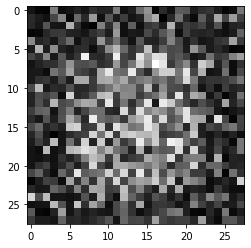

Epoch [1/200], Step [200/600], d_loss: 0.0873, g_loss: 4.5296, D(x): 0.96, D(G(z)): 0.04
Epoch [1/200], Step [400/600], d_loss: 0.2281, g_loss: 3.5588, D(x): 0.90, D(G(z)): 0.09
Epoch [1/200], Step [600/600], d_loss: 0.1050, g_loss: 4.6470, D(x): 0.97, D(G(z)): 0.06


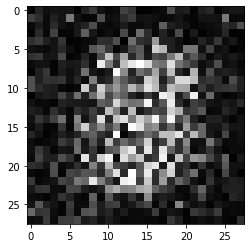

Epoch [2/200], Step [200/600], d_loss: 0.1252, g_loss: 3.3944, D(x): 0.96, D(G(z)): 0.07
Epoch [2/200], Step [400/600], d_loss: 0.3100, g_loss: 3.1094, D(x): 0.85, D(G(z)): 0.07
Epoch [2/200], Step [600/600], d_loss: 0.7250, g_loss: 2.2657, D(x): 0.80, D(G(z)): 0.30


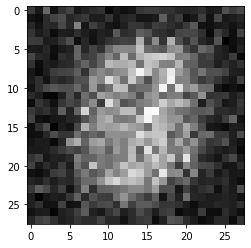

Epoch [3/200], Step [200/600], d_loss: 0.1769, g_loss: 4.6883, D(x): 0.94, D(G(z)): 0.06
Epoch [3/200], Step [400/600], d_loss: 0.9625, g_loss: 2.8965, D(x): 0.75, D(G(z)): 0.27
Epoch [3/200], Step [600/600], d_loss: 0.1695, g_loss: 3.7596, D(x): 0.95, D(G(z)): 0.09


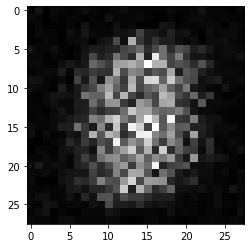

Epoch [4/200], Step [200/600], d_loss: 0.1909, g_loss: 2.8163, D(x): 0.93, D(G(z)): 0.08
Epoch [4/200], Step [400/600], d_loss: 0.7418, g_loss: 2.7372, D(x): 0.75, D(G(z)): 0.13
Epoch [4/200], Step [600/600], d_loss: 0.2719, g_loss: 4.3071, D(x): 0.89, D(G(z)): 0.02


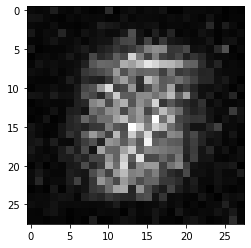

Epoch [5/200], Step [200/600], d_loss: 0.4963, g_loss: 2.8653, D(x): 0.86, D(G(z)): 0.12
Epoch [5/200], Step [400/600], d_loss: 0.3019, g_loss: 3.1673, D(x): 0.92, D(G(z)): 0.12
Epoch [5/200], Step [600/600], d_loss: 0.8957, g_loss: 2.7531, D(x): 0.87, D(G(z)): 0.38


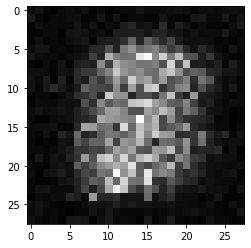

Epoch [6/200], Step [200/600], d_loss: 0.2180, g_loss: 3.4279, D(x): 0.88, D(G(z)): 0.04
Epoch [6/200], Step [400/600], d_loss: 0.3525, g_loss: 4.3565, D(x): 0.89, D(G(z)): 0.15
Epoch [6/200], Step [600/600], d_loss: 0.1829, g_loss: 3.0259, D(x): 0.94, D(G(z)): 0.10


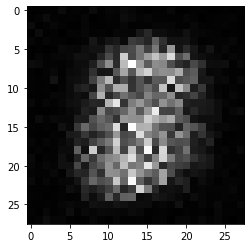

Epoch [7/200], Step [200/600], d_loss: 0.2630, g_loss: 3.7716, D(x): 0.90, D(G(z)): 0.08
Epoch [7/200], Step [400/600], d_loss: 0.1841, g_loss: 4.3820, D(x): 0.95, D(G(z)): 0.09
Epoch [7/200], Step [600/600], d_loss: 0.3104, g_loss: 4.6357, D(x): 0.88, D(G(z)): 0.03


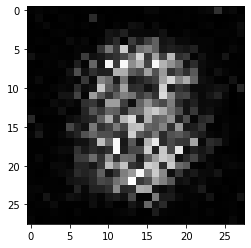

Epoch [8/200], Step [200/600], d_loss: 0.2140, g_loss: 4.3007, D(x): 0.94, D(G(z)): 0.08
Epoch [8/200], Step [400/600], d_loss: 0.1712, g_loss: 4.3387, D(x): 0.95, D(G(z)): 0.03
Epoch [8/200], Step [600/600], d_loss: 0.1915, g_loss: 3.8491, D(x): 0.96, D(G(z)): 0.12


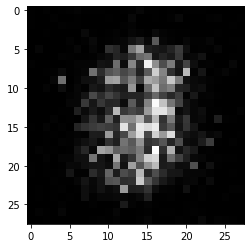

Epoch [9/200], Step [200/600], d_loss: 0.2625, g_loss: 2.7585, D(x): 0.94, D(G(z)): 0.12
Epoch [9/200], Step [400/600], d_loss: 0.1661, g_loss: 4.3516, D(x): 0.94, D(G(z)): 0.05
Epoch [9/200], Step [600/600], d_loss: 0.1490, g_loss: 3.8458, D(x): 0.95, D(G(z)): 0.05


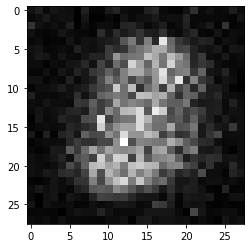

Epoch [10/200], Step [200/600], d_loss: 0.2014, g_loss: 5.2313, D(x): 0.93, D(G(z)): 0.05
Epoch [10/200], Step [400/600], d_loss: 0.0961, g_loss: 3.7887, D(x): 0.99, D(G(z)): 0.07
Epoch [10/200], Step [600/600], d_loss: 0.1111, g_loss: 6.6670, D(x): 0.95, D(G(z)): 0.01


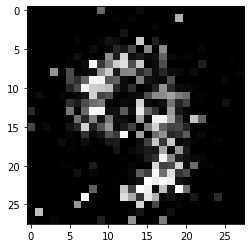

Epoch [11/200], Step [200/600], d_loss: 0.1760, g_loss: 4.7433, D(x): 0.96, D(G(z)): 0.06
Epoch [11/200], Step [400/600], d_loss: 0.2148, g_loss: 4.7818, D(x): 0.92, D(G(z)): 0.02
Epoch [11/200], Step [600/600], d_loss: 0.1861, g_loss: 4.4835, D(x): 0.93, D(G(z)): 0.02


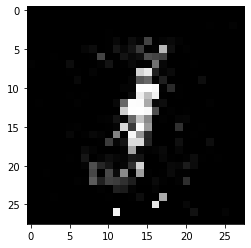

Epoch [12/200], Step [200/600], d_loss: 0.1067, g_loss: 5.4208, D(x): 0.96, D(G(z)): 0.04
Epoch [12/200], Step [400/600], d_loss: 0.0641, g_loss: 4.3842, D(x): 0.98, D(G(z)): 0.03
Epoch [12/200], Step [600/600], d_loss: 0.3358, g_loss: 5.1515, D(x): 0.97, D(G(z)): 0.21


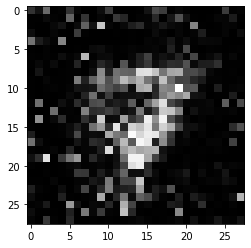

Epoch [13/200], Step [200/600], d_loss: 0.2075, g_loss: 4.7623, D(x): 0.94, D(G(z)): 0.05
Epoch [13/200], Step [400/600], d_loss: 0.1384, g_loss: 6.1500, D(x): 0.97, D(G(z)): 0.08
Epoch [13/200], Step [600/600], d_loss: 0.1746, g_loss: 4.9548, D(x): 0.93, D(G(z)): 0.03


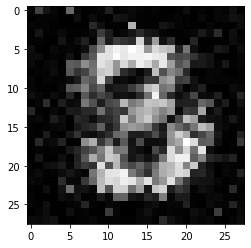

Epoch [14/200], Step [200/600], d_loss: 0.2738, g_loss: 5.7231, D(x): 0.91, D(G(z)): 0.01
Epoch [14/200], Step [400/600], d_loss: 0.2263, g_loss: 5.1973, D(x): 0.93, D(G(z)): 0.05
Epoch [14/200], Step [600/600], d_loss: 0.1498, g_loss: 6.3461, D(x): 0.94, D(G(z)): 0.03


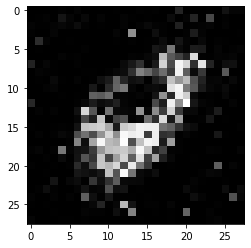

Epoch [15/200], Step [200/600], d_loss: 0.4673, g_loss: 5.0689, D(x): 0.85, D(G(z)): 0.02
Epoch [15/200], Step [400/600], d_loss: 0.3474, g_loss: 4.3723, D(x): 0.89, D(G(z)): 0.02
Epoch [15/200], Step [600/600], d_loss: 0.2250, g_loss: 4.8726, D(x): 0.91, D(G(z)): 0.01


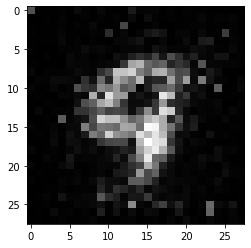

Epoch [16/200], Step [200/600], d_loss: 0.1850, g_loss: 5.2326, D(x): 0.96, D(G(z)): 0.06
Epoch [16/200], Step [400/600], d_loss: 0.3233, g_loss: 4.9400, D(x): 0.88, D(G(z)): 0.01
Epoch [16/200], Step [600/600], d_loss: 0.2115, g_loss: 3.6090, D(x): 0.92, D(G(z)): 0.02


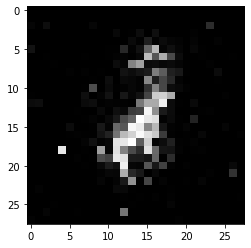

Epoch [17/200], Step [200/600], d_loss: 0.2698, g_loss: 4.4383, D(x): 0.88, D(G(z)): 0.03
Epoch [17/200], Step [400/600], d_loss: 0.1168, g_loss: 4.7954, D(x): 0.95, D(G(z)): 0.04
Epoch [17/200], Step [600/600], d_loss: 0.1734, g_loss: 5.0323, D(x): 0.94, D(G(z)): 0.03


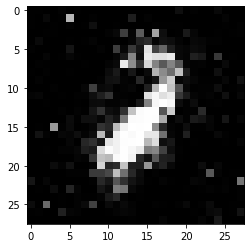

Epoch [18/200], Step [200/600], d_loss: 0.3846, g_loss: 4.2861, D(x): 0.93, D(G(z)): 0.18
Epoch [18/200], Step [400/600], d_loss: 0.1763, g_loss: 5.1510, D(x): 0.96, D(G(z)): 0.09
Epoch [18/200], Step [600/600], d_loss: 0.1654, g_loss: 4.9281, D(x): 0.95, D(G(z)): 0.06


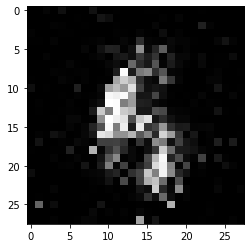

Epoch [19/200], Step [200/600], d_loss: 0.1512, g_loss: 4.7814, D(x): 0.97, D(G(z)): 0.04
Epoch [19/200], Step [400/600], d_loss: 0.1725, g_loss: 5.9546, D(x): 0.95, D(G(z)): 0.06
Epoch [19/200], Step [600/600], d_loss: 0.2173, g_loss: 5.4087, D(x): 0.97, D(G(z)): 0.10


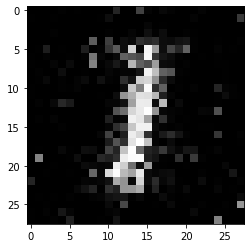

Epoch [20/200], Step [200/600], d_loss: 0.2942, g_loss: 3.7170, D(x): 0.94, D(G(z)): 0.13
Epoch [20/200], Step [400/600], d_loss: 0.1866, g_loss: 4.9944, D(x): 0.98, D(G(z)): 0.11
Epoch [20/200], Step [600/600], d_loss: 0.2945, g_loss: 5.3741, D(x): 0.90, D(G(z)): 0.03


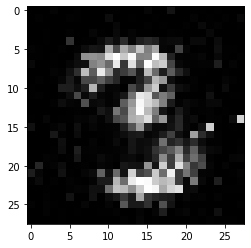

Epoch [21/200], Step [200/600], d_loss: 0.5176, g_loss: 5.7811, D(x): 0.85, D(G(z)): 0.07
Epoch [21/200], Step [400/600], d_loss: 0.2126, g_loss: 4.5702, D(x): 0.93, D(G(z)): 0.06
Epoch [21/200], Step [600/600], d_loss: 0.2424, g_loss: 5.6710, D(x): 0.93, D(G(z)): 0.07


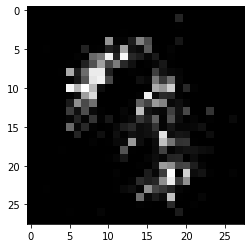

Epoch [22/200], Step [200/600], d_loss: 0.1299, g_loss: 4.3054, D(x): 0.95, D(G(z)): 0.05
Epoch [22/200], Step [400/600], d_loss: 0.2595, g_loss: 3.8129, D(x): 0.88, D(G(z)): 0.04
Epoch [22/200], Step [600/600], d_loss: 0.2153, g_loss: 4.2982, D(x): 0.94, D(G(z)): 0.06


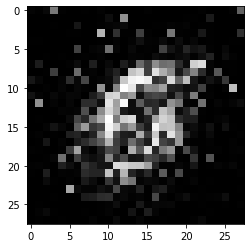

Epoch [23/200], Step [200/600], d_loss: 0.3254, g_loss: 4.1780, D(x): 0.93, D(G(z)): 0.09
Epoch [23/200], Step [400/600], d_loss: 0.2961, g_loss: 5.3704, D(x): 0.97, D(G(z)): 0.17
Epoch [23/200], Step [600/600], d_loss: 0.3137, g_loss: 5.3206, D(x): 0.90, D(G(z)): 0.03


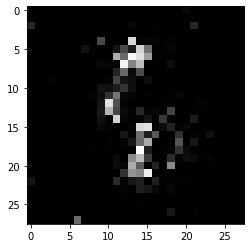

Epoch [24/200], Step [200/600], d_loss: 0.1989, g_loss: 5.0683, D(x): 0.93, D(G(z)): 0.06
Epoch [24/200], Step [400/600], d_loss: 0.3487, g_loss: 4.3645, D(x): 0.85, D(G(z)): 0.05
Epoch [24/200], Step [600/600], d_loss: 0.3306, g_loss: 5.3999, D(x): 0.93, D(G(z)): 0.08


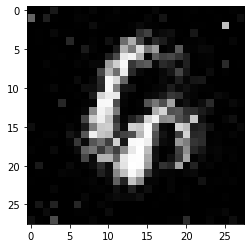

Epoch [25/200], Step [200/600], d_loss: 0.3043, g_loss: 3.7532, D(x): 0.90, D(G(z)): 0.08
Epoch [25/200], Step [400/600], d_loss: 0.1868, g_loss: 4.6005, D(x): 0.96, D(G(z)): 0.08
Epoch [25/200], Step [600/600], d_loss: 0.1157, g_loss: 4.0294, D(x): 0.96, D(G(z)): 0.04


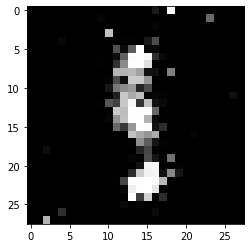

Epoch [26/200], Step [200/600], d_loss: 0.5254, g_loss: 4.0024, D(x): 0.88, D(G(z)): 0.13
Epoch [26/200], Step [400/600], d_loss: 0.2972, g_loss: 3.5076, D(x): 0.93, D(G(z)): 0.12
Epoch [26/200], Step [600/600], d_loss: 0.1825, g_loss: 3.6276, D(x): 0.95, D(G(z)): 0.07


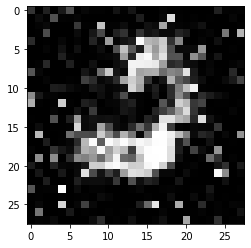

Epoch [27/200], Step [200/600], d_loss: 0.4369, g_loss: 3.7667, D(x): 0.92, D(G(z)): 0.17
Epoch [27/200], Step [400/600], d_loss: 0.1042, g_loss: 5.0441, D(x): 0.97, D(G(z)): 0.06
Epoch [27/200], Step [600/600], d_loss: 0.6249, g_loss: 4.5122, D(x): 0.87, D(G(z)): 0.21


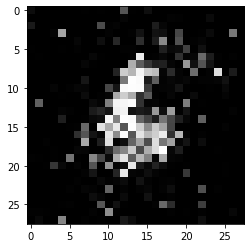

Epoch [28/200], Step [200/600], d_loss: 0.2396, g_loss: 4.2861, D(x): 0.96, D(G(z)): 0.13
Epoch [28/200], Step [400/600], d_loss: 0.3174, g_loss: 4.0208, D(x): 0.90, D(G(z)): 0.11
Epoch [28/200], Step [600/600], d_loss: 0.2970, g_loss: 3.1055, D(x): 0.92, D(G(z)): 0.13


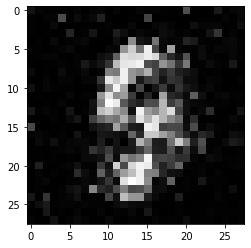

Epoch [29/200], Step [200/600], d_loss: 0.3704, g_loss: 3.6934, D(x): 0.88, D(G(z)): 0.08
Epoch [29/200], Step [400/600], d_loss: 0.3705, g_loss: 4.7308, D(x): 0.91, D(G(z)): 0.12
Epoch [29/200], Step [600/600], d_loss: 0.4415, g_loss: 2.6636, D(x): 0.88, D(G(z)): 0.10


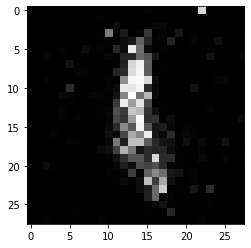

Epoch [30/200], Step [200/600], d_loss: 0.3115, g_loss: 4.1098, D(x): 0.94, D(G(z)): 0.11
Epoch [30/200], Step [400/600], d_loss: 0.4564, g_loss: 3.0807, D(x): 0.87, D(G(z)): 0.15
Epoch [30/200], Step [600/600], d_loss: 0.6224, g_loss: 3.3975, D(x): 0.79, D(G(z)): 0.03


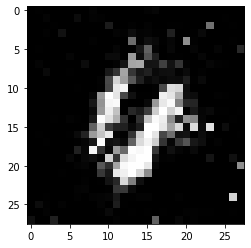

Epoch [31/200], Step [200/600], d_loss: 0.3701, g_loss: 4.5677, D(x): 0.85, D(G(z)): 0.07
Epoch [31/200], Step [400/600], d_loss: 0.3567, g_loss: 3.7318, D(x): 0.87, D(G(z)): 0.06
Epoch [31/200], Step [600/600], d_loss: 0.3863, g_loss: 2.5271, D(x): 0.94, D(G(z)): 0.20


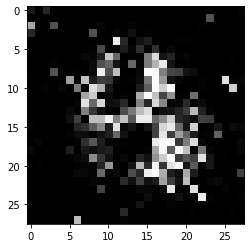

Epoch [32/200], Step [200/600], d_loss: 0.5548, g_loss: 3.7887, D(x): 0.90, D(G(z)): 0.25
Epoch [32/200], Step [400/600], d_loss: 0.4913, g_loss: 2.6195, D(x): 0.89, D(G(z)): 0.19
Epoch [32/200], Step [600/600], d_loss: 0.3650, g_loss: 3.2280, D(x): 0.86, D(G(z)): 0.08


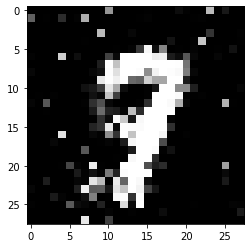

Epoch [33/200], Step [200/600], d_loss: 0.6292, g_loss: 2.9026, D(x): 0.87, D(G(z)): 0.20
Epoch [33/200], Step [400/600], d_loss: 0.4731, g_loss: 2.9493, D(x): 0.83, D(G(z)): 0.11
Epoch [33/200], Step [600/600], d_loss: 0.3060, g_loss: 3.5183, D(x): 0.94, D(G(z)): 0.15


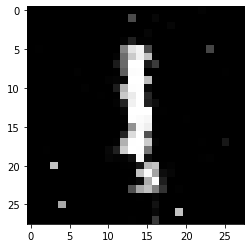

Epoch [34/200], Step [200/600], d_loss: 0.3987, g_loss: 3.0280, D(x): 0.86, D(G(z)): 0.11
Epoch [34/200], Step [400/600], d_loss: 0.3822, g_loss: 3.5214, D(x): 0.85, D(G(z)): 0.10
Epoch [34/200], Step [600/600], d_loss: 0.7135, g_loss: 4.2757, D(x): 0.76, D(G(z)): 0.06


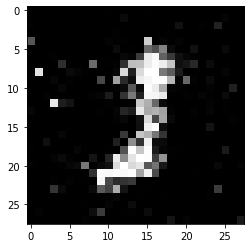

Epoch [35/200], Step [200/600], d_loss: 0.4557, g_loss: 3.9529, D(x): 0.81, D(G(z)): 0.05
Epoch [35/200], Step [400/600], d_loss: 0.4051, g_loss: 3.1329, D(x): 0.86, D(G(z)): 0.12
Epoch [35/200], Step [600/600], d_loss: 0.3955, g_loss: 3.6077, D(x): 0.92, D(G(z)): 0.20


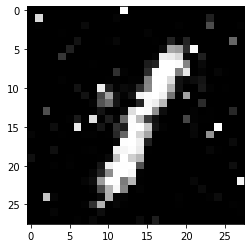

Epoch [36/200], Step [200/600], d_loss: 0.4005, g_loss: 3.6522, D(x): 0.89, D(G(z)): 0.13
Epoch [36/200], Step [400/600], d_loss: 0.4432, g_loss: 4.1176, D(x): 0.87, D(G(z)): 0.13
Epoch [36/200], Step [600/600], d_loss: 0.4322, g_loss: 3.6922, D(x): 0.83, D(G(z)): 0.06


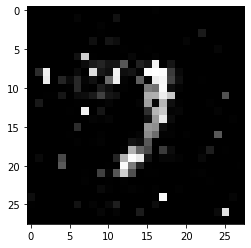

Epoch [37/200], Step [200/600], d_loss: 0.3674, g_loss: 3.4688, D(x): 0.94, D(G(z)): 0.19
Epoch [37/200], Step [400/600], d_loss: 0.2920, g_loss: 3.8110, D(x): 0.88, D(G(z)): 0.08
Epoch [37/200], Step [600/600], d_loss: 0.4783, g_loss: 3.4439, D(x): 0.81, D(G(z)): 0.10


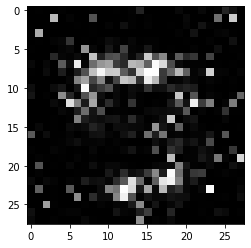

Epoch [38/200], Step [200/600], d_loss: 0.6230, g_loss: 3.3927, D(x): 0.87, D(G(z)): 0.21
Epoch [38/200], Step [400/600], d_loss: 0.2656, g_loss: 4.6666, D(x): 0.89, D(G(z)): 0.07
Epoch [38/200], Step [600/600], d_loss: 0.3880, g_loss: 4.1022, D(x): 0.86, D(G(z)): 0.09


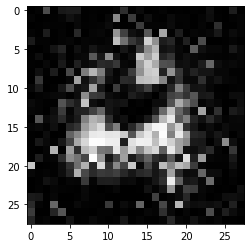

Epoch [39/200], Step [200/600], d_loss: 0.4427, g_loss: 3.0515, D(x): 0.84, D(G(z)): 0.07
Epoch [39/200], Step [400/600], d_loss: 0.3885, g_loss: 2.9886, D(x): 0.88, D(G(z)): 0.13
Epoch [39/200], Step [600/600], d_loss: 0.5173, g_loss: 3.0647, D(x): 0.86, D(G(z)): 0.20


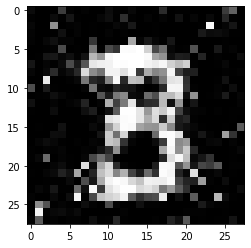

Epoch [40/200], Step [200/600], d_loss: 0.4246, g_loss: 3.1867, D(x): 0.84, D(G(z)): 0.11
Epoch [40/200], Step [400/600], d_loss: 0.5624, g_loss: 3.7289, D(x): 0.86, D(G(z)): 0.16
Epoch [40/200], Step [600/600], d_loss: 0.5079, g_loss: 3.6075, D(x): 0.83, D(G(z)): 0.14


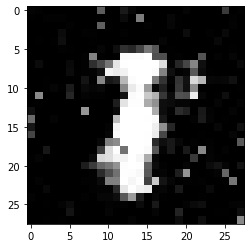

Epoch [41/200], Step [200/600], d_loss: 0.5208, g_loss: 2.6960, D(x): 0.91, D(G(z)): 0.25
Epoch [41/200], Step [400/600], d_loss: 0.6283, g_loss: 2.7854, D(x): 0.86, D(G(z)): 0.22
Epoch [41/200], Step [600/600], d_loss: 0.4663, g_loss: 2.5246, D(x): 0.81, D(G(z)): 0.11


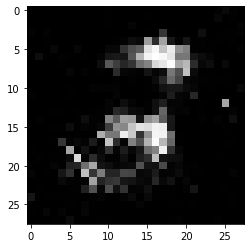

Epoch [42/200], Step [200/600], d_loss: 0.5662, g_loss: 1.8909, D(x): 0.85, D(G(z)): 0.23
Epoch [42/200], Step [400/600], d_loss: 0.4321, g_loss: 2.9657, D(x): 0.87, D(G(z)): 0.16
Epoch [42/200], Step [600/600], d_loss: 0.6928, g_loss: 1.7458, D(x): 0.76, D(G(z)): 0.15


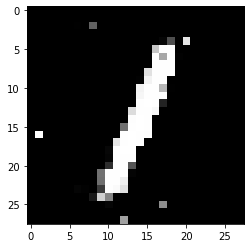

Epoch [43/200], Step [200/600], d_loss: 0.8160, g_loss: 2.2753, D(x): 0.86, D(G(z)): 0.33
Epoch [43/200], Step [400/600], d_loss: 0.4829, g_loss: 2.7467, D(x): 0.84, D(G(z)): 0.16
Epoch [43/200], Step [600/600], d_loss: 0.6173, g_loss: 2.8252, D(x): 0.76, D(G(z)): 0.12


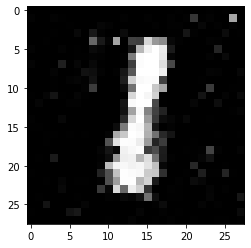

Epoch [44/200], Step [200/600], d_loss: 0.5950, g_loss: 2.3412, D(x): 0.87, D(G(z)): 0.27
Epoch [44/200], Step [400/600], d_loss: 0.4078, g_loss: 2.3755, D(x): 0.87, D(G(z)): 0.17
Epoch [44/200], Step [600/600], d_loss: 0.6979, g_loss: 2.1702, D(x): 0.80, D(G(z)): 0.25


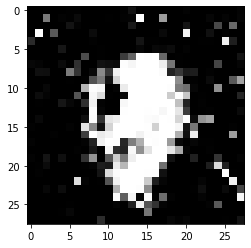

Epoch [45/200], Step [200/600], d_loss: 0.6819, g_loss: 2.8002, D(x): 0.85, D(G(z)): 0.29
Epoch [45/200], Step [400/600], d_loss: 0.6189, g_loss: 2.9005, D(x): 0.85, D(G(z)): 0.23
Epoch [45/200], Step [600/600], d_loss: 0.6662, g_loss: 2.0405, D(x): 0.85, D(G(z)): 0.27


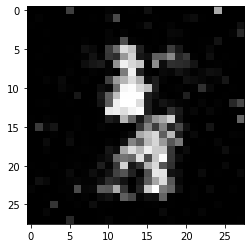

Epoch [46/200], Step [200/600], d_loss: 0.4987, g_loss: 2.0482, D(x): 0.87, D(G(z)): 0.20
Epoch [46/200], Step [400/600], d_loss: 0.4357, g_loss: 2.6991, D(x): 0.91, D(G(z)): 0.18
Epoch [46/200], Step [600/600], d_loss: 0.4141, g_loss: 3.8126, D(x): 0.82, D(G(z)): 0.08


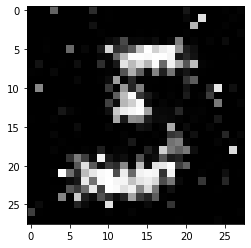

Epoch [47/200], Step [200/600], d_loss: 0.4236, g_loss: 2.9436, D(x): 0.87, D(G(z)): 0.14
Epoch [47/200], Step [400/600], d_loss: 0.5898, g_loss: 3.9700, D(x): 0.81, D(G(z)): 0.14
Epoch [47/200], Step [600/600], d_loss: 0.3114, g_loss: 4.1752, D(x): 0.93, D(G(z)): 0.15


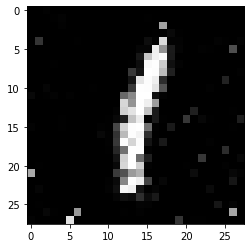

Epoch [48/200], Step [200/600], d_loss: 0.3481, g_loss: 3.9844, D(x): 0.92, D(G(z)): 0.14
Epoch [48/200], Step [400/600], d_loss: 0.3720, g_loss: 5.1370, D(x): 0.92, D(G(z)): 0.16
Epoch [48/200], Step [600/600], d_loss: 0.4148, g_loss: 4.2827, D(x): 0.83, D(G(z)): 0.08


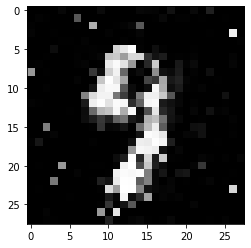

Epoch [49/200], Step [200/600], d_loss: 0.3623, g_loss: 3.6088, D(x): 0.85, D(G(z)): 0.10
Epoch [49/200], Step [400/600], d_loss: 0.6572, g_loss: 3.0491, D(x): 0.81, D(G(z)): 0.19
Epoch [49/200], Step [600/600], d_loss: 0.7086, g_loss: 2.2704, D(x): 0.83, D(G(z)): 0.20


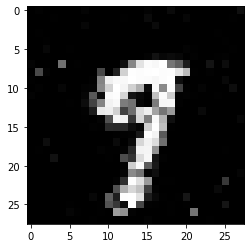

Epoch [50/200], Step [200/600], d_loss: 0.4823, g_loss: 2.7353, D(x): 0.85, D(G(z)): 0.18
Epoch [50/200], Step [400/600], d_loss: 0.3825, g_loss: 2.9498, D(x): 0.90, D(G(z)): 0.15
Epoch [50/200], Step [600/600], d_loss: 0.5225, g_loss: 2.2833, D(x): 0.87, D(G(z)): 0.22


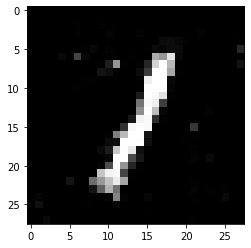

Epoch [51/200], Step [200/600], d_loss: 0.5606, g_loss: 2.2878, D(x): 0.89, D(G(z)): 0.29
Epoch [51/200], Step [400/600], d_loss: 0.6204, g_loss: 2.7370, D(x): 0.82, D(G(z)): 0.19
Epoch [51/200], Step [600/600], d_loss: 0.7690, g_loss: 2.5598, D(x): 0.82, D(G(z)): 0.30


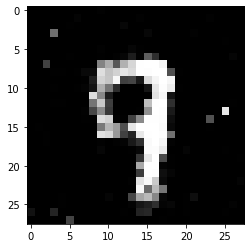

Epoch [52/200], Step [200/600], d_loss: 0.7719, g_loss: 1.9689, D(x): 0.78, D(G(z)): 0.22
Epoch [52/200], Step [400/600], d_loss: 0.4614, g_loss: 2.9497, D(x): 0.89, D(G(z)): 0.23
Epoch [52/200], Step [600/600], d_loss: 0.5870, g_loss: 2.2487, D(x): 0.83, D(G(z)): 0.24


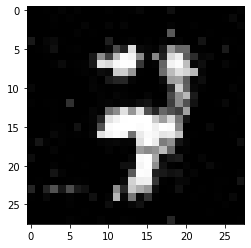

Epoch [53/200], Step [200/600], d_loss: 0.5233, g_loss: 2.4657, D(x): 0.86, D(G(z)): 0.23
Epoch [53/200], Step [400/600], d_loss: 0.6918, g_loss: 2.2735, D(x): 0.75, D(G(z)): 0.16
Epoch [53/200], Step [600/600], d_loss: 0.5995, g_loss: 2.9420, D(x): 0.84, D(G(z)): 0.21


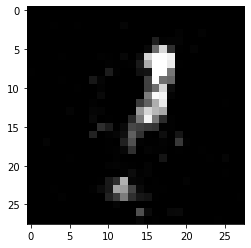

Epoch [54/200], Step [200/600], d_loss: 0.6898, g_loss: 2.7736, D(x): 0.71, D(G(z)): 0.11
Epoch [54/200], Step [400/600], d_loss: 0.6496, g_loss: 2.4040, D(x): 0.85, D(G(z)): 0.27
Epoch [54/200], Step [600/600], d_loss: 0.7660, g_loss: 1.8697, D(x): 0.73, D(G(z)): 0.19


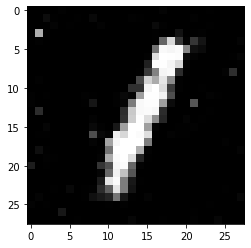

Epoch [55/200], Step [200/600], d_loss: 0.7340, g_loss: 2.0220, D(x): 0.78, D(G(z)): 0.22
Epoch [55/200], Step [400/600], d_loss: 0.6339, g_loss: 2.8482, D(x): 0.79, D(G(z)): 0.19
Epoch [55/200], Step [600/600], d_loss: 0.7853, g_loss: 2.2511, D(x): 0.89, D(G(z)): 0.37


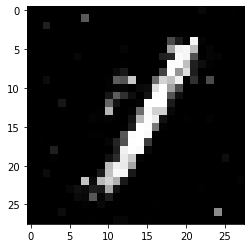

Epoch [56/200], Step [200/600], d_loss: 0.6311, g_loss: 1.9096, D(x): 0.76, D(G(z)): 0.17
Epoch [56/200], Step [400/600], d_loss: 0.6284, g_loss: 2.0948, D(x): 0.79, D(G(z)): 0.21
Epoch [56/200], Step [600/600], d_loss: 0.4283, g_loss: 2.5974, D(x): 0.89, D(G(z)): 0.19


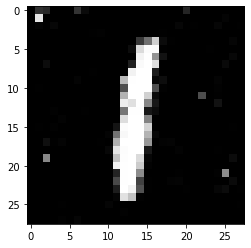

Epoch [57/200], Step [200/600], d_loss: 0.5442, g_loss: 2.5702, D(x): 0.84, D(G(z)): 0.20
Epoch [57/200], Step [400/600], d_loss: 0.5003, g_loss: 2.2739, D(x): 0.88, D(G(z)): 0.21
Epoch [57/200], Step [600/600], d_loss: 0.5937, g_loss: 2.9703, D(x): 0.81, D(G(z)): 0.17


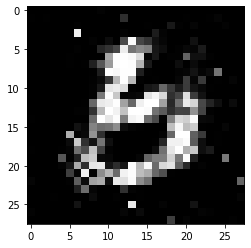

Epoch [58/200], Step [200/600], d_loss: 0.5827, g_loss: 2.2594, D(x): 0.82, D(G(z)): 0.19
Epoch [58/200], Step [400/600], d_loss: 0.6811, g_loss: 2.4479, D(x): 0.73, D(G(z)): 0.16
Epoch [58/200], Step [600/600], d_loss: 0.4814, g_loss: 2.6914, D(x): 0.91, D(G(z)): 0.22


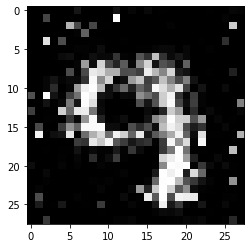

Epoch [59/200], Step [200/600], d_loss: 0.4454, g_loss: 2.7894, D(x): 0.84, D(G(z)): 0.12
Epoch [59/200], Step [400/600], d_loss: 0.4860, g_loss: 3.3070, D(x): 0.84, D(G(z)): 0.16
Epoch [59/200], Step [600/600], d_loss: 0.4225, g_loss: 3.2737, D(x): 0.88, D(G(z)): 0.16


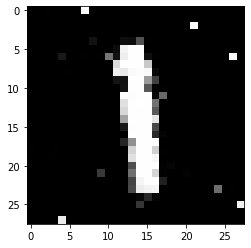

Epoch [60/200], Step [200/600], d_loss: 0.6600, g_loss: 3.0216, D(x): 0.83, D(G(z)): 0.20
Epoch [60/200], Step [400/600], d_loss: 0.5469, g_loss: 2.5804, D(x): 0.83, D(G(z)): 0.19
Epoch [60/200], Step [600/600], d_loss: 0.7811, g_loss: 2.8366, D(x): 0.94, D(G(z)): 0.38


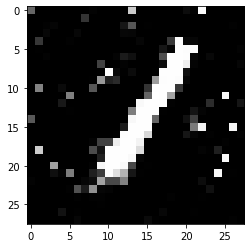

Epoch [61/200], Step [200/600], d_loss: 0.4375, g_loss: 2.8782, D(x): 0.84, D(G(z)): 0.14
Epoch [61/200], Step [400/600], d_loss: 0.5939, g_loss: 3.1135, D(x): 0.76, D(G(z)): 0.11
Epoch [61/200], Step [600/600], d_loss: 0.6013, g_loss: 3.0509, D(x): 0.85, D(G(z)): 0.26


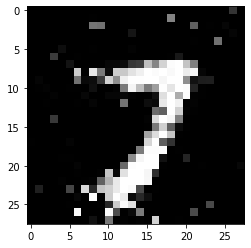

Epoch [62/200], Step [200/600], d_loss: 0.7096, g_loss: 2.5686, D(x): 0.87, D(G(z)): 0.28
Epoch [62/200], Step [400/600], d_loss: 0.7066, g_loss: 2.4474, D(x): 0.84, D(G(z)): 0.28
Epoch [62/200], Step [600/600], d_loss: 0.7050, g_loss: 2.3958, D(x): 0.68, D(G(z)): 0.12


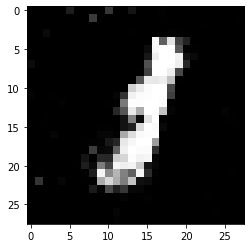

Epoch [63/200], Step [200/600], d_loss: 0.7458, g_loss: 2.3904, D(x): 0.82, D(G(z)): 0.32
Epoch [63/200], Step [400/600], d_loss: 0.7229, g_loss: 2.1028, D(x): 0.78, D(G(z)): 0.24
Epoch [63/200], Step [600/600], d_loss: 0.4314, g_loss: 2.6220, D(x): 0.86, D(G(z)): 0.18


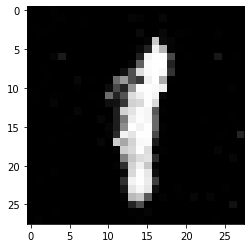

Epoch [64/200], Step [200/600], d_loss: 0.6947, g_loss: 2.3956, D(x): 0.79, D(G(z)): 0.23
Epoch [64/200], Step [400/600], d_loss: 0.8297, g_loss: 2.3239, D(x): 0.66, D(G(z)): 0.12
Epoch [64/200], Step [600/600], d_loss: 0.7659, g_loss: 1.8501, D(x): 0.77, D(G(z)): 0.27


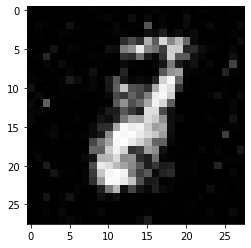

Epoch [65/200], Step [200/600], d_loss: 0.8784, g_loss: 1.5973, D(x): 0.72, D(G(z)): 0.24
Epoch [65/200], Step [400/600], d_loss: 0.7743, g_loss: 2.0548, D(x): 0.80, D(G(z)): 0.28
Epoch [65/200], Step [600/600], d_loss: 0.7177, g_loss: 2.1380, D(x): 0.81, D(G(z)): 0.25


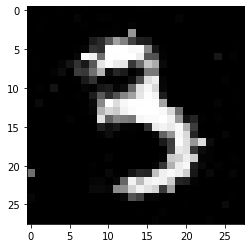

Epoch [66/200], Step [200/600], d_loss: 0.6080, g_loss: 2.4199, D(x): 0.79, D(G(z)): 0.20
Epoch [66/200], Step [400/600], d_loss: 0.6189, g_loss: 2.7614, D(x): 0.78, D(G(z)): 0.19
Epoch [66/200], Step [600/600], d_loss: 0.8070, g_loss: 1.7991, D(x): 0.81, D(G(z)): 0.31


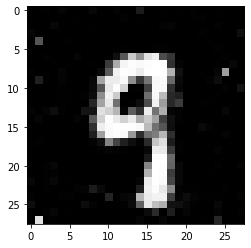

Epoch [67/200], Step [200/600], d_loss: 0.6993, g_loss: 2.5551, D(x): 0.72, D(G(z)): 0.15
Epoch [67/200], Step [400/600], d_loss: 0.9909, g_loss: 2.0564, D(x): 0.74, D(G(z)): 0.28
Epoch [67/200], Step [600/600], d_loss: 0.8415, g_loss: 1.7671, D(x): 0.75, D(G(z)): 0.27


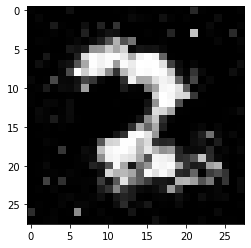

Epoch [68/200], Step [200/600], d_loss: 0.6033, g_loss: 1.5615, D(x): 0.77, D(G(z)): 0.17
Epoch [68/200], Step [400/600], d_loss: 0.7706, g_loss: 2.4742, D(x): 0.77, D(G(z)): 0.27
Epoch [68/200], Step [600/600], d_loss: 0.9090, g_loss: 2.5463, D(x): 0.65, D(G(z)): 0.17


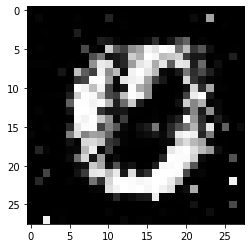

Epoch [69/200], Step [200/600], d_loss: 0.6469, g_loss: 2.3572, D(x): 0.77, D(G(z)): 0.20
Epoch [69/200], Step [400/600], d_loss: 0.8007, g_loss: 2.7776, D(x): 0.67, D(G(z)): 0.13
Epoch [69/200], Step [600/600], d_loss: 0.7309, g_loss: 1.9847, D(x): 0.83, D(G(z)): 0.30


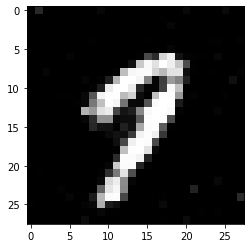

Epoch [70/200], Step [200/600], d_loss: 0.7211, g_loss: 1.6213, D(x): 0.82, D(G(z)): 0.32
Epoch [70/200], Step [400/600], d_loss: 0.7633, g_loss: 2.2761, D(x): 0.72, D(G(z)): 0.17
Epoch [70/200], Step [600/600], d_loss: 0.6559, g_loss: 1.9084, D(x): 0.78, D(G(z)): 0.19


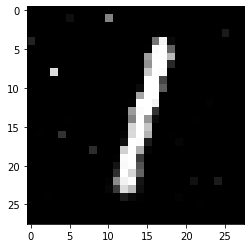

Epoch [71/200], Step [200/600], d_loss: 0.6544, g_loss: 2.0922, D(x): 0.78, D(G(z)): 0.24
Epoch [71/200], Step [400/600], d_loss: 0.6062, g_loss: 2.5234, D(x): 0.86, D(G(z)): 0.26
Epoch [71/200], Step [600/600], d_loss: 0.7586, g_loss: 2.5735, D(x): 0.73, D(G(z)): 0.16


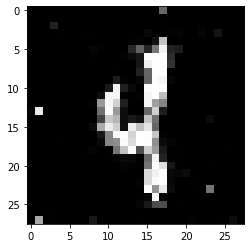

Epoch [72/200], Step [200/600], d_loss: 0.8086, g_loss: 1.7969, D(x): 0.85, D(G(z)): 0.38
Epoch [72/200], Step [400/600], d_loss: 0.5499, g_loss: 2.5493, D(x): 0.86, D(G(z)): 0.24
Epoch [72/200], Step [600/600], d_loss: 0.6068, g_loss: 2.6601, D(x): 0.86, D(G(z)): 0.26


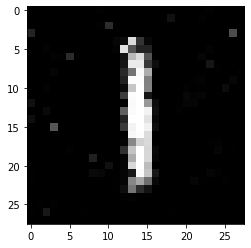

Epoch [73/200], Step [200/600], d_loss: 0.7662, g_loss: 2.8781, D(x): 0.70, D(G(z)): 0.16
Epoch [73/200], Step [400/600], d_loss: 0.7571, g_loss: 1.7618, D(x): 0.87, D(G(z)): 0.36
Epoch [73/200], Step [600/600], d_loss: 0.5944, g_loss: 2.1803, D(x): 0.80, D(G(z)): 0.22


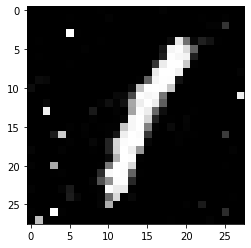

Epoch [74/200], Step [200/600], d_loss: 0.6180, g_loss: 3.0989, D(x): 0.75, D(G(z)): 0.12
Epoch [74/200], Step [400/600], d_loss: 0.5511, g_loss: 2.4766, D(x): 0.84, D(G(z)): 0.23
Epoch [74/200], Step [600/600], d_loss: 0.9747, g_loss: 2.4889, D(x): 0.62, D(G(z)): 0.16


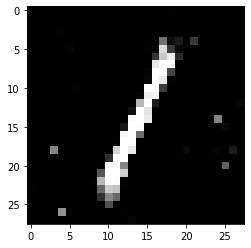

Epoch [75/200], Step [200/600], d_loss: 0.8062, g_loss: 2.1667, D(x): 0.81, D(G(z)): 0.32
Epoch [75/200], Step [400/600], d_loss: 0.7353, g_loss: 1.9001, D(x): 0.80, D(G(z)): 0.26
Epoch [75/200], Step [600/600], d_loss: 0.6413, g_loss: 3.0152, D(x): 0.77, D(G(z)): 0.17


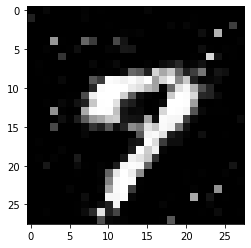

Epoch [76/200], Step [200/600], d_loss: 0.6214, g_loss: 2.5960, D(x): 0.77, D(G(z)): 0.19
Epoch [76/200], Step [400/600], d_loss: 0.7101, g_loss: 2.3006, D(x): 0.85, D(G(z)): 0.31
Epoch [76/200], Step [600/600], d_loss: 0.6249, g_loss: 2.7496, D(x): 0.76, D(G(z)): 0.16


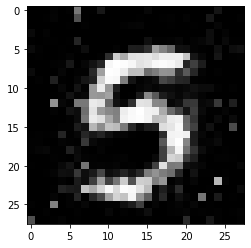

Epoch [77/200], Step [200/600], d_loss: 0.8323, g_loss: 1.5219, D(x): 0.70, D(G(z)): 0.21
Epoch [77/200], Step [400/600], d_loss: 0.6282, g_loss: 1.8974, D(x): 0.78, D(G(z)): 0.22
Epoch [77/200], Step [600/600], d_loss: 0.7248, g_loss: 1.7544, D(x): 0.80, D(G(z)): 0.28


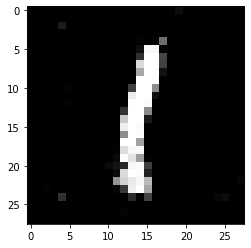

Epoch [78/200], Step [200/600], d_loss: 0.9710, g_loss: 2.2447, D(x): 0.77, D(G(z)): 0.34
Epoch [78/200], Step [400/600], d_loss: 0.6640, g_loss: 2.2218, D(x): 0.77, D(G(z)): 0.22
Epoch [78/200], Step [600/600], d_loss: 0.9146, g_loss: 2.2151, D(x): 0.72, D(G(z)): 0.26


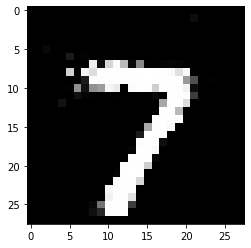

Epoch [79/200], Step [200/600], d_loss: 0.7199, g_loss: 1.7919, D(x): 0.75, D(G(z)): 0.22
Epoch [79/200], Step [400/600], d_loss: 0.7349, g_loss: 1.8634, D(x): 0.77, D(G(z)): 0.26
Epoch [79/200], Step [600/600], d_loss: 1.0556, g_loss: 1.5993, D(x): 0.69, D(G(z)): 0.33


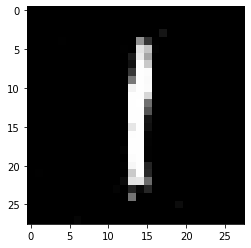

Epoch [80/200], Step [200/600], d_loss: 0.6683, g_loss: 1.6957, D(x): 0.76, D(G(z)): 0.23
Epoch [80/200], Step [400/600], d_loss: 0.9544, g_loss: 1.9332, D(x): 0.67, D(G(z)): 0.21
Epoch [80/200], Step [600/600], d_loss: 0.5952, g_loss: 2.1055, D(x): 0.82, D(G(z)): 0.24


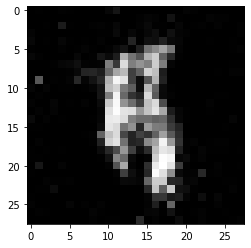

Epoch [81/200], Step [200/600], d_loss: 0.8620, g_loss: 2.2026, D(x): 0.70, D(G(z)): 0.26
Epoch [81/200], Step [400/600], d_loss: 0.7924, g_loss: 1.9805, D(x): 0.70, D(G(z)): 0.19
Epoch [81/200], Step [600/600], d_loss: 0.7685, g_loss: 2.0088, D(x): 0.74, D(G(z)): 0.25


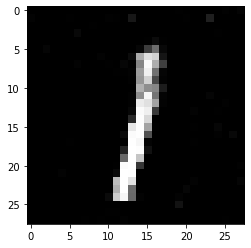

Epoch [82/200], Step [200/600], d_loss: 0.6338, g_loss: 1.9441, D(x): 0.85, D(G(z)): 0.30
Epoch [82/200], Step [400/600], d_loss: 0.7432, g_loss: 1.9722, D(x): 0.77, D(G(z)): 0.24
Epoch [82/200], Step [600/600], d_loss: 0.8020, g_loss: 1.8246, D(x): 0.73, D(G(z)): 0.22


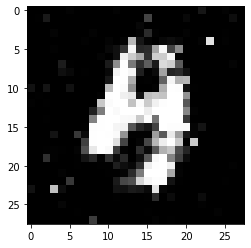

Epoch [83/200], Step [200/600], d_loss: 0.7056, g_loss: 1.9586, D(x): 0.81, D(G(z)): 0.27
Epoch [83/200], Step [400/600], d_loss: 0.5518, g_loss: 2.0775, D(x): 0.80, D(G(z)): 0.21
Epoch [83/200], Step [600/600], d_loss: 0.7306, g_loss: 1.8815, D(x): 0.78, D(G(z)): 0.25


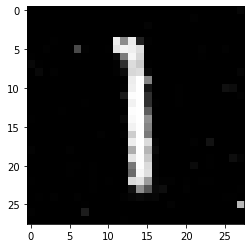

Epoch [84/200], Step [200/600], d_loss: 0.6359, g_loss: 2.4519, D(x): 0.73, D(G(z)): 0.16
Epoch [84/200], Step [400/600], d_loss: 0.7083, g_loss: 1.9469, D(x): 0.73, D(G(z)): 0.18
Epoch [84/200], Step [600/600], d_loss: 1.0233, g_loss: 1.4590, D(x): 0.63, D(G(z)): 0.25


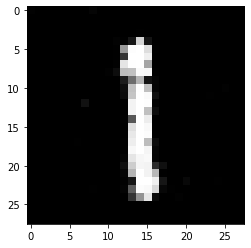

Epoch [85/200], Step [200/600], d_loss: 0.5868, g_loss: 2.1590, D(x): 0.80, D(G(z)): 0.22
Epoch [85/200], Step [400/600], d_loss: 0.8344, g_loss: 2.1409, D(x): 0.85, D(G(z)): 0.37
Epoch [85/200], Step [600/600], d_loss: 0.5949, g_loss: 2.1648, D(x): 0.80, D(G(z)): 0.21


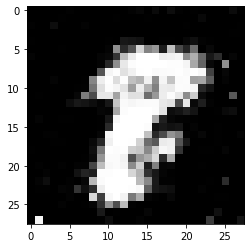

Epoch [86/200], Step [200/600], d_loss: 0.8274, g_loss: 2.5171, D(x): 0.82, D(G(z)): 0.35
Epoch [86/200], Step [400/600], d_loss: 0.8699, g_loss: 2.0943, D(x): 0.77, D(G(z)): 0.31
Epoch [86/200], Step [600/600], d_loss: 0.8874, g_loss: 2.1636, D(x): 0.71, D(G(z)): 0.24


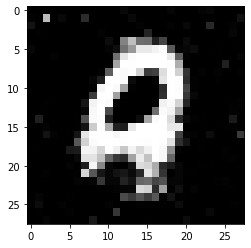

Epoch [87/200], Step [200/600], d_loss: 0.8264, g_loss: 1.5507, D(x): 0.82, D(G(z)): 0.34
Epoch [87/200], Step [400/600], d_loss: 0.8711, g_loss: 2.0043, D(x): 0.68, D(G(z)): 0.23
Epoch [87/200], Step [600/600], d_loss: 0.6196, g_loss: 2.0392, D(x): 0.83, D(G(z)): 0.24


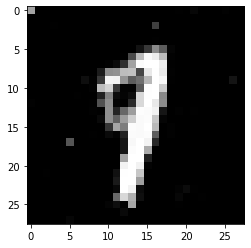

Epoch [88/200], Step [200/600], d_loss: 0.7774, g_loss: 1.9407, D(x): 0.77, D(G(z)): 0.30
Epoch [88/200], Step [400/600], d_loss: 0.7232, g_loss: 1.9874, D(x): 0.74, D(G(z)): 0.21
Epoch [88/200], Step [600/600], d_loss: 0.7269, g_loss: 1.7390, D(x): 0.82, D(G(z)): 0.32


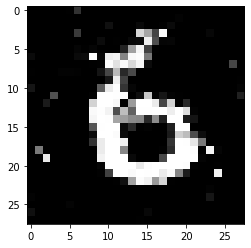

Epoch [89/200], Step [200/600], d_loss: 0.8226, g_loss: 1.8115, D(x): 0.73, D(G(z)): 0.25
Epoch [89/200], Step [400/600], d_loss: 0.7204, g_loss: 2.6375, D(x): 0.77, D(G(z)): 0.24
Epoch [89/200], Step [600/600], d_loss: 0.8020, g_loss: 2.0257, D(x): 0.69, D(G(z)): 0.18


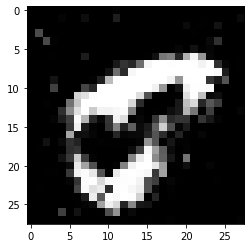

Epoch [90/200], Step [200/600], d_loss: 0.7480, g_loss: 2.2617, D(x): 0.77, D(G(z)): 0.24
Epoch [90/200], Step [400/600], d_loss: 0.7138, g_loss: 1.6254, D(x): 0.75, D(G(z)): 0.22
Epoch [90/200], Step [600/600], d_loss: 0.6340, g_loss: 1.9503, D(x): 0.80, D(G(z)): 0.23


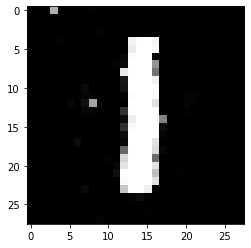

Epoch [91/200], Step [200/600], d_loss: 0.6830, g_loss: 2.0107, D(x): 0.76, D(G(z)): 0.22
Epoch [91/200], Step [400/600], d_loss: 0.6807, g_loss: 2.0197, D(x): 0.83, D(G(z)): 0.32
Epoch [91/200], Step [600/600], d_loss: 0.7545, g_loss: 1.7747, D(x): 0.70, D(G(z)): 0.21


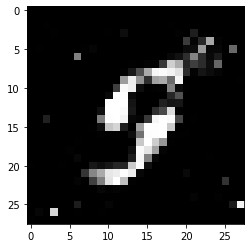

Epoch [92/200], Step [200/600], d_loss: 0.7317, g_loss: 1.9599, D(x): 0.70, D(G(z)): 0.18
Epoch [92/200], Step [400/600], d_loss: 0.8257, g_loss: 1.7520, D(x): 0.75, D(G(z)): 0.29
Epoch [92/200], Step [600/600], d_loss: 0.7642, g_loss: 1.9666, D(x): 0.70, D(G(z)): 0.19


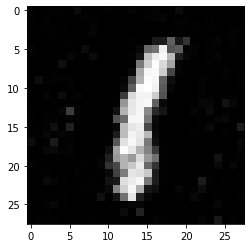

Epoch [93/200], Step [200/600], d_loss: 0.8505, g_loss: 1.3904, D(x): 0.72, D(G(z)): 0.24
Epoch [93/200], Step [400/600], d_loss: 0.8101, g_loss: 2.2445, D(x): 0.66, D(G(z)): 0.18
Epoch [93/200], Step [600/600], d_loss: 0.9192, g_loss: 2.0275, D(x): 0.69, D(G(z)): 0.27


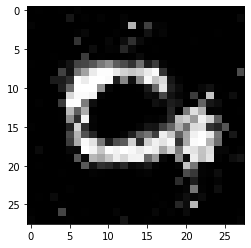

Epoch [94/200], Step [200/600], d_loss: 0.7690, g_loss: 1.8960, D(x): 0.75, D(G(z)): 0.26
Epoch [94/200], Step [400/600], d_loss: 0.7384, g_loss: 1.9726, D(x): 0.79, D(G(z)): 0.28
Epoch [94/200], Step [600/600], d_loss: 0.8536, g_loss: 1.7336, D(x): 0.81, D(G(z)): 0.34


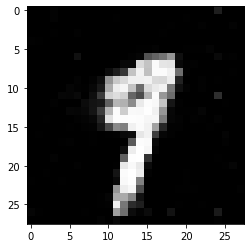

Epoch [95/200], Step [200/600], d_loss: 0.7686, g_loss: 1.8513, D(x): 0.77, D(G(z)): 0.27
Epoch [95/200], Step [400/600], d_loss: 0.8502, g_loss: 1.4863, D(x): 0.72, D(G(z)): 0.30
Epoch [95/200], Step [600/600], d_loss: 0.8350, g_loss: 2.4914, D(x): 0.73, D(G(z)): 0.25


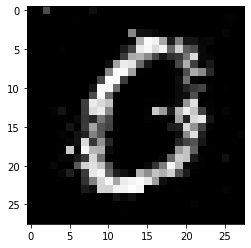

Epoch [96/200], Step [200/600], d_loss: 0.7780, g_loss: 2.0177, D(x): 0.74, D(G(z)): 0.26
Epoch [96/200], Step [400/600], d_loss: 0.7433, g_loss: 1.5658, D(x): 0.78, D(G(z)): 0.25
Epoch [96/200], Step [600/600], d_loss: 0.7466, g_loss: 1.8914, D(x): 0.79, D(G(z)): 0.29


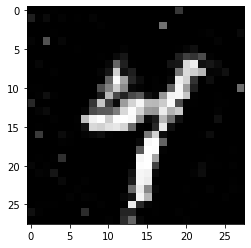

Epoch [97/200], Step [200/600], d_loss: 0.8668, g_loss: 1.8594, D(x): 0.78, D(G(z)): 0.32
Epoch [97/200], Step [400/600], d_loss: 0.6380, g_loss: 1.9812, D(x): 0.76, D(G(z)): 0.20
Epoch [97/200], Step [600/600], d_loss: 0.9314, g_loss: 1.6758, D(x): 0.75, D(G(z)): 0.33


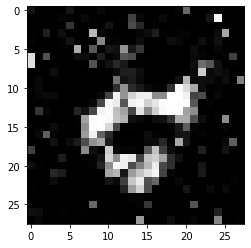

Epoch [98/200], Step [200/600], d_loss: 0.6982, g_loss: 1.7879, D(x): 0.77, D(G(z)): 0.24
Epoch [98/200], Step [400/600], d_loss: 0.6350, g_loss: 2.2403, D(x): 0.76, D(G(z)): 0.17
Epoch [98/200], Step [600/600], d_loss: 0.9199, g_loss: 2.1700, D(x): 0.72, D(G(z)): 0.29


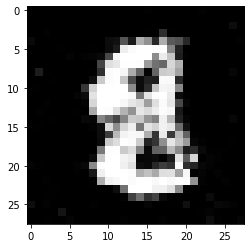

Epoch [99/200], Step [200/600], d_loss: 1.0037, g_loss: 2.1736, D(x): 0.75, D(G(z)): 0.39
Epoch [99/200], Step [400/600], d_loss: 0.8034, g_loss: 2.3908, D(x): 0.67, D(G(z)): 0.16
Epoch [99/200], Step [600/600], d_loss: 0.6817, g_loss: 2.1266, D(x): 0.75, D(G(z)): 0.24


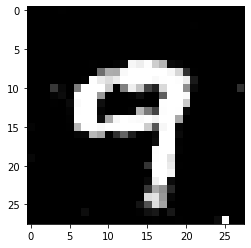

Epoch [100/200], Step [200/600], d_loss: 0.9074, g_loss: 2.0602, D(x): 0.71, D(G(z)): 0.31
Epoch [100/200], Step [400/600], d_loss: 0.7486, g_loss: 2.0927, D(x): 0.71, D(G(z)): 0.18
Epoch [100/200], Step [600/600], d_loss: 0.7566, g_loss: 1.6873, D(x): 0.72, D(G(z)): 0.22


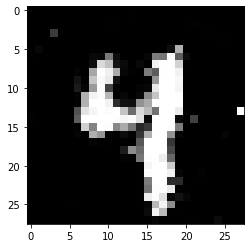

Epoch [101/200], Step [200/600], d_loss: 0.8265, g_loss: 2.0341, D(x): 0.67, D(G(z)): 0.16
Epoch [101/200], Step [400/600], d_loss: 0.8099, g_loss: 2.4795, D(x): 0.74, D(G(z)): 0.26
Epoch [101/200], Step [600/600], d_loss: 0.8264, g_loss: 2.5248, D(x): 0.70, D(G(z)): 0.21


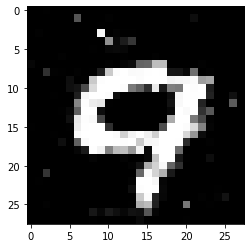

Epoch [102/200], Step [200/600], d_loss: 0.6475, g_loss: 1.7788, D(x): 0.78, D(G(z)): 0.23
Epoch [102/200], Step [400/600], d_loss: 0.8349, g_loss: 1.8596, D(x): 0.75, D(G(z)): 0.31
Epoch [102/200], Step [600/600], d_loss: 0.7190, g_loss: 2.5898, D(x): 0.71, D(G(z)): 0.16


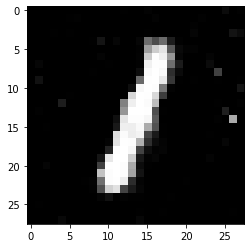

Epoch [103/200], Step [200/600], d_loss: 0.8350, g_loss: 2.0509, D(x): 0.73, D(G(z)): 0.27
Epoch [103/200], Step [400/600], d_loss: 0.7731, g_loss: 1.9903, D(x): 0.73, D(G(z)): 0.28
Epoch [103/200], Step [600/600], d_loss: 0.7120, g_loss: 1.9706, D(x): 0.78, D(G(z)): 0.26


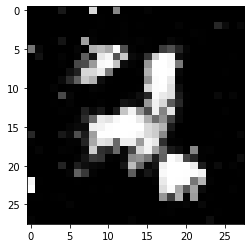

Epoch [104/200], Step [200/600], d_loss: 0.9784, g_loss: 1.6140, D(x): 0.72, D(G(z)): 0.31
Epoch [104/200], Step [400/600], d_loss: 0.7815, g_loss: 1.7414, D(x): 0.73, D(G(z)): 0.25
Epoch [104/200], Step [600/600], d_loss: 0.9482, g_loss: 1.8703, D(x): 0.75, D(G(z)): 0.36


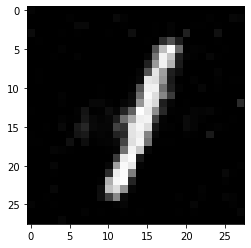

Epoch [105/200], Step [200/600], d_loss: 0.8775, g_loss: 1.6571, D(x): 0.73, D(G(z)): 0.29
Epoch [105/200], Step [400/600], d_loss: 0.9211, g_loss: 2.2945, D(x): 0.68, D(G(z)): 0.24
Epoch [105/200], Step [600/600], d_loss: 0.8321, g_loss: 1.7502, D(x): 0.73, D(G(z)): 0.28


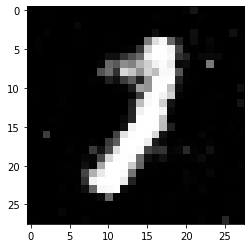

Epoch [106/200], Step [200/600], d_loss: 0.8727, g_loss: 1.9262, D(x): 0.66, D(G(z)): 0.21
Epoch [106/200], Step [400/600], d_loss: 0.6891, g_loss: 2.5087, D(x): 0.73, D(G(z)): 0.18
Epoch [106/200], Step [600/600], d_loss: 0.9668, g_loss: 1.7251, D(x): 0.78, D(G(z)): 0.39


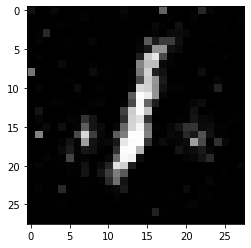

Epoch [107/200], Step [200/600], d_loss: 0.7663, g_loss: 1.6826, D(x): 0.79, D(G(z)): 0.28
Epoch [107/200], Step [400/600], d_loss: 1.0471, g_loss: 2.0794, D(x): 0.65, D(G(z)): 0.24
Epoch [107/200], Step [600/600], d_loss: 0.9855, g_loss: 1.4883, D(x): 0.66, D(G(z)): 0.26


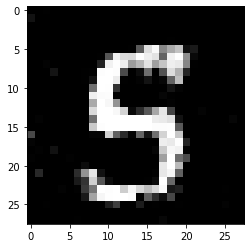

Epoch [108/200], Step [200/600], d_loss: 0.7857, g_loss: 2.1982, D(x): 0.77, D(G(z)): 0.30
Epoch [108/200], Step [400/600], d_loss: 0.8636, g_loss: 1.5100, D(x): 0.65, D(G(z)): 0.20
Epoch [108/200], Step [600/600], d_loss: 0.9445, g_loss: 1.6706, D(x): 0.76, D(G(z)): 0.38


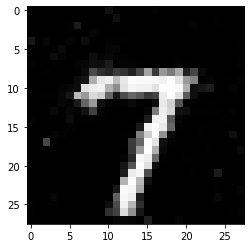

Epoch [109/200], Step [200/600], d_loss: 0.8892, g_loss: 1.5965, D(x): 0.72, D(G(z)): 0.27
Epoch [109/200], Step [400/600], d_loss: 0.9013, g_loss: 1.9944, D(x): 0.69, D(G(z)): 0.28
Epoch [109/200], Step [600/600], d_loss: 0.8272, g_loss: 1.9359, D(x): 0.69, D(G(z)): 0.25


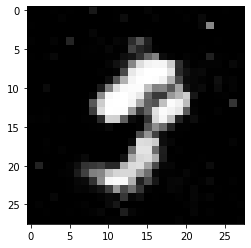

Epoch [110/200], Step [200/600], d_loss: 1.1038, g_loss: 1.6244, D(x): 0.70, D(G(z)): 0.36
Epoch [110/200], Step [400/600], d_loss: 0.6459, g_loss: 2.4219, D(x): 0.80, D(G(z)): 0.24
Epoch [110/200], Step [600/600], d_loss: 0.7938, g_loss: 1.6740, D(x): 0.74, D(G(z)): 0.27


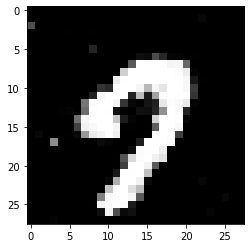

Epoch [111/200], Step [200/600], d_loss: 0.7111, g_loss: 1.4865, D(x): 0.80, D(G(z)): 0.29
Epoch [111/200], Step [400/600], d_loss: 0.6494, g_loss: 1.6019, D(x): 0.75, D(G(z)): 0.22
Epoch [111/200], Step [600/600], d_loss: 0.8300, g_loss: 1.3470, D(x): 0.72, D(G(z)): 0.27


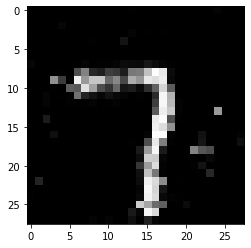

Epoch [112/200], Step [200/600], d_loss: 0.9664, g_loss: 1.5406, D(x): 0.75, D(G(z)): 0.36
Epoch [112/200], Step [400/600], d_loss: 0.7679, g_loss: 1.9197, D(x): 0.76, D(G(z)): 0.27
Epoch [112/200], Step [600/600], d_loss: 0.7735, g_loss: 1.5290, D(x): 0.76, D(G(z)): 0.27


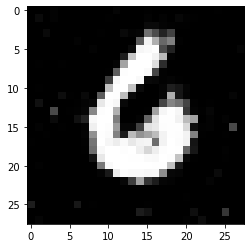

Epoch [113/200], Step [200/600], d_loss: 0.9450, g_loss: 1.5796, D(x): 0.67, D(G(z)): 0.29
Epoch [113/200], Step [400/600], d_loss: 0.9427, g_loss: 1.6698, D(x): 0.73, D(G(z)): 0.29
Epoch [113/200], Step [600/600], d_loss: 0.6936, g_loss: 2.3853, D(x): 0.77, D(G(z)): 0.25


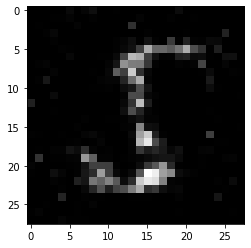

Epoch [114/200], Step [200/600], d_loss: 1.1006, g_loss: 1.5574, D(x): 0.63, D(G(z)): 0.29
Epoch [114/200], Step [400/600], d_loss: 0.8479, g_loss: 1.9622, D(x): 0.70, D(G(z)): 0.26
Epoch [114/200], Step [600/600], d_loss: 0.7679, g_loss: 1.8110, D(x): 0.77, D(G(z)): 0.27


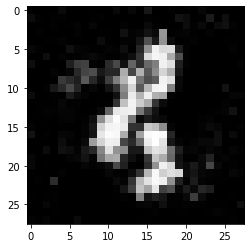

Epoch [115/200], Step [200/600], d_loss: 0.7843, g_loss: 1.5012, D(x): 0.77, D(G(z)): 0.31
Epoch [115/200], Step [400/600], d_loss: 1.0505, g_loss: 1.8220, D(x): 0.78, D(G(z)): 0.39
Epoch [115/200], Step [600/600], d_loss: 0.8277, g_loss: 2.3178, D(x): 0.74, D(G(z)): 0.29


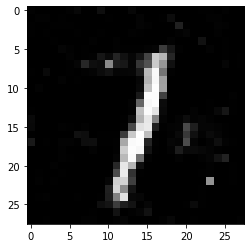

Epoch [116/200], Step [200/600], d_loss: 0.8577, g_loss: 1.6658, D(x): 0.71, D(G(z)): 0.30
Epoch [116/200], Step [400/600], d_loss: 0.9328, g_loss: 1.6570, D(x): 0.69, D(G(z)): 0.29
Epoch [116/200], Step [600/600], d_loss: 1.0771, g_loss: 1.4480, D(x): 0.66, D(G(z)): 0.33


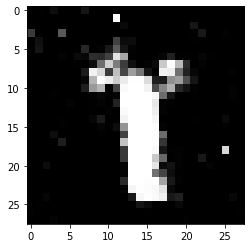

Epoch [117/200], Step [200/600], d_loss: 0.9788, g_loss: 1.7643, D(x): 0.72, D(G(z)): 0.35
Epoch [117/200], Step [400/600], d_loss: 0.9028, g_loss: 1.6030, D(x): 0.75, D(G(z)): 0.36
Epoch [117/200], Step [600/600], d_loss: 0.6972, g_loss: 1.6803, D(x): 0.79, D(G(z)): 0.27


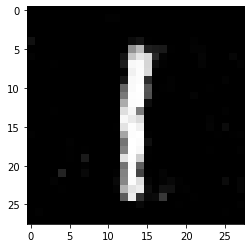

Epoch [118/200], Step [200/600], d_loss: 0.7978, g_loss: 1.8307, D(x): 0.66, D(G(z)): 0.19
Epoch [118/200], Step [400/600], d_loss: 0.8816, g_loss: 1.6608, D(x): 0.70, D(G(z)): 0.29
Epoch [118/200], Step [600/600], d_loss: 0.8114, g_loss: 2.1892, D(x): 0.78, D(G(z)): 0.31


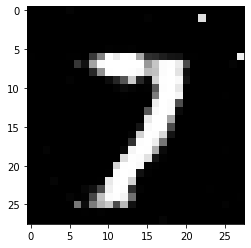

Epoch [119/200], Step [200/600], d_loss: 0.8797, g_loss: 1.8746, D(x): 0.73, D(G(z)): 0.30
Epoch [119/200], Step [400/600], d_loss: 0.9270, g_loss: 1.4565, D(x): 0.77, D(G(z)): 0.40
Epoch [119/200], Step [600/600], d_loss: 0.8637, g_loss: 2.0914, D(x): 0.65, D(G(z)): 0.20


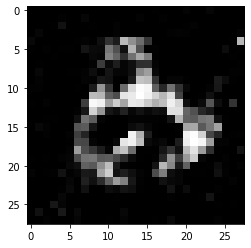

Epoch [120/200], Step [200/600], d_loss: 0.8559, g_loss: 1.3457, D(x): 0.79, D(G(z)): 0.34
Epoch [120/200], Step [400/600], d_loss: 0.7268, g_loss: 2.0742, D(x): 0.73, D(G(z)): 0.23
Epoch [120/200], Step [600/600], d_loss: 0.9905, g_loss: 1.5082, D(x): 0.68, D(G(z)): 0.31


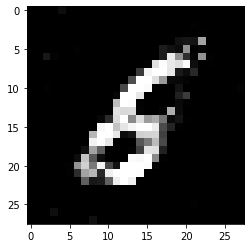

Epoch [121/200], Step [200/600], d_loss: 0.9559, g_loss: 1.5676, D(x): 0.71, D(G(z)): 0.34
Epoch [121/200], Step [400/600], d_loss: 0.9124, g_loss: 1.7190, D(x): 0.64, D(G(z)): 0.23
Epoch [121/200], Step [600/600], d_loss: 0.8256, g_loss: 1.6305, D(x): 0.72, D(G(z)): 0.28


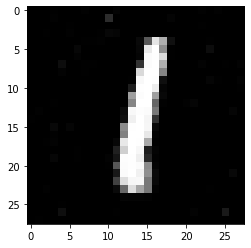

Epoch [122/200], Step [200/600], d_loss: 1.0172, g_loss: 1.6152, D(x): 0.64, D(G(z)): 0.26
Epoch [122/200], Step [400/600], d_loss: 0.8196, g_loss: 1.4847, D(x): 0.74, D(G(z)): 0.31
Epoch [122/200], Step [600/600], d_loss: 0.8402, g_loss: 1.9011, D(x): 0.79, D(G(z)): 0.34


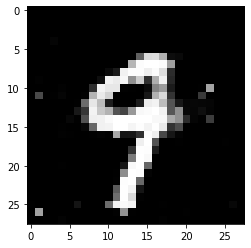

Epoch [123/200], Step [200/600], d_loss: 0.7819, g_loss: 1.9171, D(x): 0.73, D(G(z)): 0.27
Epoch [123/200], Step [400/600], d_loss: 0.8096, g_loss: 1.8817, D(x): 0.72, D(G(z)): 0.25
Epoch [123/200], Step [600/600], d_loss: 0.7531, g_loss: 1.6088, D(x): 0.72, D(G(z)): 0.25


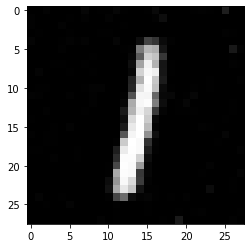

Epoch [124/200], Step [200/600], d_loss: 0.8597, g_loss: 1.5879, D(x): 0.74, D(G(z)): 0.28
Epoch [124/200], Step [400/600], d_loss: 0.9786, g_loss: 1.2701, D(x): 0.70, D(G(z)): 0.30
Epoch [124/200], Step [600/600], d_loss: 0.7891, g_loss: 2.0554, D(x): 0.78, D(G(z)): 0.32


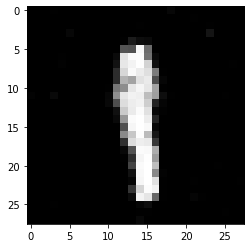

Epoch [125/200], Step [200/600], d_loss: 0.7980, g_loss: 1.5284, D(x): 0.71, D(G(z)): 0.23
Epoch [125/200], Step [400/600], d_loss: 0.7430, g_loss: 1.9145, D(x): 0.75, D(G(z)): 0.27
Epoch [125/200], Step [600/600], d_loss: 1.1895, g_loss: 1.3043, D(x): 0.69, D(G(z)): 0.41


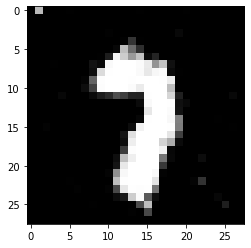

Epoch [126/200], Step [200/600], d_loss: 0.8567, g_loss: 1.5913, D(x): 0.68, D(G(z)): 0.24
Epoch [126/200], Step [400/600], d_loss: 1.0493, g_loss: 1.5840, D(x): 0.62, D(G(z)): 0.23
Epoch [126/200], Step [600/600], d_loss: 0.8807, g_loss: 1.5712, D(x): 0.66, D(G(z)): 0.24


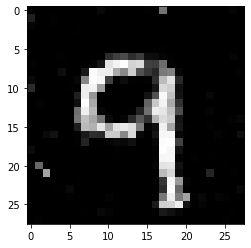

Epoch [127/200], Step [200/600], d_loss: 0.8623, g_loss: 1.6148, D(x): 0.70, D(G(z)): 0.30
Epoch [127/200], Step [400/600], d_loss: 0.9858, g_loss: 1.5694, D(x): 0.68, D(G(z)): 0.32
Epoch [127/200], Step [600/600], d_loss: 0.8724, g_loss: 1.5625, D(x): 0.78, D(G(z)): 0.36


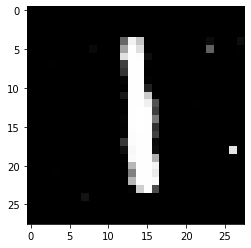

Epoch [128/200], Step [200/600], d_loss: 0.9743, g_loss: 1.6613, D(x): 0.72, D(G(z)): 0.36
Epoch [128/200], Step [400/600], d_loss: 0.7987, g_loss: 1.6221, D(x): 0.73, D(G(z)): 0.27
Epoch [128/200], Step [600/600], d_loss: 1.0223, g_loss: 1.5307, D(x): 0.62, D(G(z)): 0.23


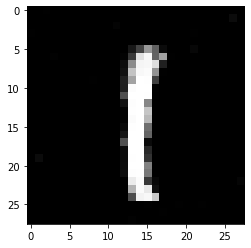

Epoch [129/200], Step [200/600], d_loss: 0.9701, g_loss: 1.9196, D(x): 0.66, D(G(z)): 0.29
Epoch [129/200], Step [400/600], d_loss: 0.8804, g_loss: 1.6735, D(x): 0.68, D(G(z)): 0.24
Epoch [129/200], Step [600/600], d_loss: 1.0505, g_loss: 1.2387, D(x): 0.61, D(G(z)): 0.25


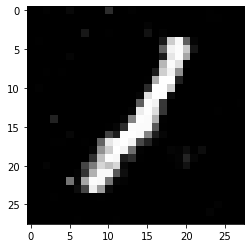

Epoch [130/200], Step [200/600], d_loss: 0.9845, g_loss: 1.3962, D(x): 0.69, D(G(z)): 0.33
Epoch [130/200], Step [400/600], d_loss: 0.8340, g_loss: 2.0319, D(x): 0.73, D(G(z)): 0.30
Epoch [130/200], Step [600/600], d_loss: 1.0818, g_loss: 1.3221, D(x): 0.75, D(G(z)): 0.41


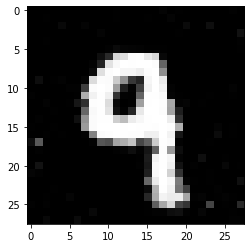

Epoch [131/200], Step [200/600], d_loss: 0.8656, g_loss: 2.1760, D(x): 0.76, D(G(z)): 0.33
Epoch [131/200], Step [400/600], d_loss: 0.8893, g_loss: 1.5859, D(x): 0.69, D(G(z)): 0.30
Epoch [131/200], Step [600/600], d_loss: 0.8939, g_loss: 1.4016, D(x): 0.67, D(G(z)): 0.25


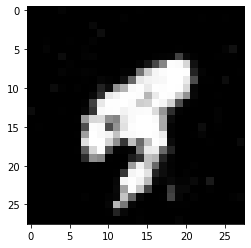

Epoch [132/200], Step [200/600], d_loss: 0.6727, g_loss: 1.6727, D(x): 0.76, D(G(z)): 0.24
Epoch [132/200], Step [400/600], d_loss: 1.1890, g_loss: 1.3242, D(x): 0.70, D(G(z)): 0.42
Epoch [132/200], Step [600/600], d_loss: 0.8975, g_loss: 1.9475, D(x): 0.68, D(G(z)): 0.25


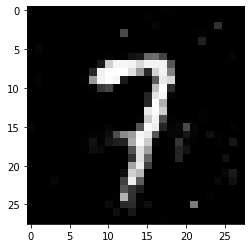

Epoch [133/200], Step [200/600], d_loss: 0.9213, g_loss: 1.5076, D(x): 0.70, D(G(z)): 0.31
Epoch [133/200], Step [400/600], d_loss: 1.0271, g_loss: 1.4112, D(x): 0.72, D(G(z)): 0.35
Epoch [133/200], Step [600/600], d_loss: 0.8154, g_loss: 1.6830, D(x): 0.70, D(G(z)): 0.27


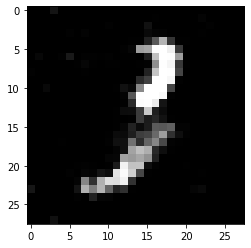

Epoch [134/200], Step [200/600], d_loss: 0.8106, g_loss: 1.9179, D(x): 0.74, D(G(z)): 0.28
Epoch [134/200], Step [400/600], d_loss: 0.7737, g_loss: 1.5383, D(x): 0.69, D(G(z)): 0.24
Epoch [134/200], Step [600/600], d_loss: 1.0636, g_loss: 1.5344, D(x): 0.64, D(G(z)): 0.31


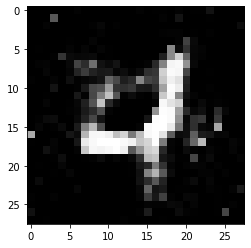

Epoch [135/200], Step [200/600], d_loss: 0.9821, g_loss: 1.4759, D(x): 0.69, D(G(z)): 0.34
Epoch [135/200], Step [400/600], d_loss: 1.0487, g_loss: 1.6799, D(x): 0.59, D(G(z)): 0.25
Epoch [135/200], Step [600/600], d_loss: 1.0476, g_loss: 1.3468, D(x): 0.69, D(G(z)): 0.35


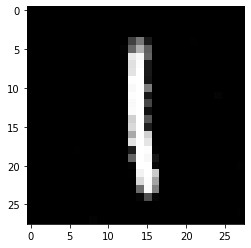

Epoch [136/200], Step [200/600], d_loss: 0.6952, g_loss: 2.1483, D(x): 0.74, D(G(z)): 0.22
Epoch [136/200], Step [400/600], d_loss: 1.0129, g_loss: 1.2161, D(x): 0.71, D(G(z)): 0.35
Epoch [136/200], Step [600/600], d_loss: 0.8981, g_loss: 1.4805, D(x): 0.75, D(G(z)): 0.34


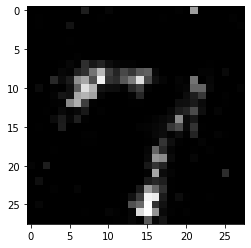

Epoch [137/200], Step [200/600], d_loss: 0.8694, g_loss: 1.8214, D(x): 0.69, D(G(z)): 0.24
Epoch [137/200], Step [400/600], d_loss: 0.8113, g_loss: 1.7721, D(x): 0.74, D(G(z)): 0.29
Epoch [137/200], Step [600/600], d_loss: 0.8724, g_loss: 1.4489, D(x): 0.70, D(G(z)): 0.31


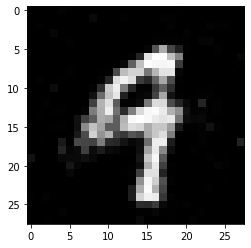

Epoch [138/200], Step [200/600], d_loss: 1.0759, g_loss: 1.9014, D(x): 0.62, D(G(z)): 0.27
Epoch [138/200], Step [400/600], d_loss: 0.9388, g_loss: 1.7642, D(x): 0.69, D(G(z)): 0.30
Epoch [138/200], Step [600/600], d_loss: 1.0921, g_loss: 1.5190, D(x): 0.70, D(G(z)): 0.40


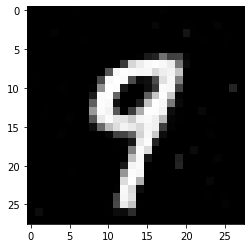

Epoch [139/200], Step [200/600], d_loss: 0.8939, g_loss: 1.6204, D(x): 0.77, D(G(z)): 0.36
Epoch [139/200], Step [400/600], d_loss: 0.9024, g_loss: 2.0826, D(x): 0.70, D(G(z)): 0.28
Epoch [139/200], Step [600/600], d_loss: 0.9077, g_loss: 1.6682, D(x): 0.71, D(G(z)): 0.33


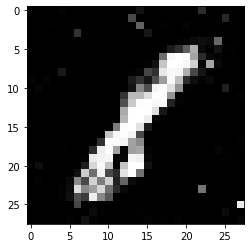

Epoch [140/200], Step [200/600], d_loss: 0.8300, g_loss: 1.7591, D(x): 0.76, D(G(z)): 0.32
Epoch [140/200], Step [400/600], d_loss: 0.8369, g_loss: 1.7139, D(x): 0.68, D(G(z)): 0.24
Epoch [140/200], Step [600/600], d_loss: 0.8212, g_loss: 2.1381, D(x): 0.73, D(G(z)): 0.27


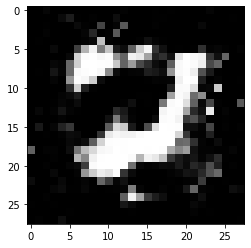

Epoch [141/200], Step [200/600], d_loss: 0.9001, g_loss: 1.4163, D(x): 0.75, D(G(z)): 0.35
Epoch [141/200], Step [400/600], d_loss: 1.0027, g_loss: 1.5598, D(x): 0.69, D(G(z)): 0.30
Epoch [141/200], Step [600/600], d_loss: 1.0142, g_loss: 1.2871, D(x): 0.77, D(G(z)): 0.38


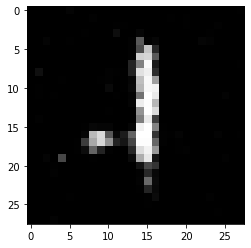

Epoch [142/200], Step [200/600], d_loss: 0.8801, g_loss: 1.6695, D(x): 0.67, D(G(z)): 0.25
Epoch [142/200], Step [400/600], d_loss: 0.9048, g_loss: 1.7327, D(x): 0.73, D(G(z)): 0.33
Epoch [142/200], Step [600/600], d_loss: 0.9044, g_loss: 1.9311, D(x): 0.66, D(G(z)): 0.24


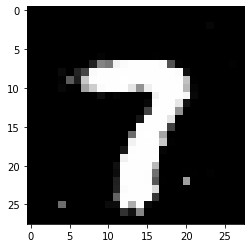

Epoch [143/200], Step [200/600], d_loss: 0.8268, g_loss: 1.6590, D(x): 0.76, D(G(z)): 0.31
Epoch [143/200], Step [400/600], d_loss: 0.7776, g_loss: 1.7261, D(x): 0.73, D(G(z)): 0.26
Epoch [143/200], Step [600/600], d_loss: 0.8035, g_loss: 1.6264, D(x): 0.79, D(G(z)): 0.34


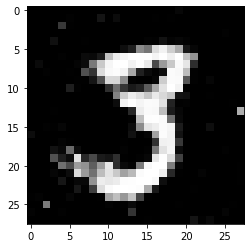

Epoch [144/200], Step [200/600], d_loss: 0.9839, g_loss: 1.6330, D(x): 0.75, D(G(z)): 0.40
Epoch [144/200], Step [400/600], d_loss: 0.8964, g_loss: 2.2306, D(x): 0.66, D(G(z)): 0.21
Epoch [144/200], Step [600/600], d_loss: 1.0128, g_loss: 1.4134, D(x): 0.66, D(G(z)): 0.30


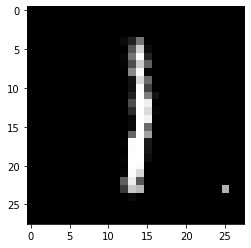

Epoch [145/200], Step [200/600], d_loss: 0.9430, g_loss: 1.5848, D(x): 0.70, D(G(z)): 0.31
Epoch [145/200], Step [400/600], d_loss: 0.9486, g_loss: 1.2589, D(x): 0.65, D(G(z)): 0.26
Epoch [145/200], Step [600/600], d_loss: 1.0458, g_loss: 1.1811, D(x): 0.68, D(G(z)): 0.37


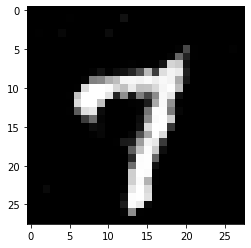

Epoch [146/200], Step [200/600], d_loss: 0.7640, g_loss: 1.7130, D(x): 0.71, D(G(z)): 0.22
Epoch [146/200], Step [400/600], d_loss: 0.8281, g_loss: 1.4795, D(x): 0.74, D(G(z)): 0.32
Epoch [146/200], Step [600/600], d_loss: 0.6369, g_loss: 1.9564, D(x): 0.80, D(G(z)): 0.27


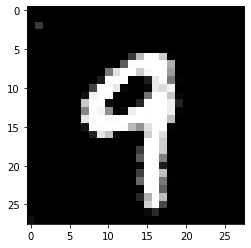

Epoch [147/200], Step [200/600], d_loss: 0.8012, g_loss: 1.6447, D(x): 0.71, D(G(z)): 0.27
Epoch [147/200], Step [400/600], d_loss: 0.9597, g_loss: 1.3265, D(x): 0.71, D(G(z)): 0.33
Epoch [147/200], Step [600/600], d_loss: 0.9744, g_loss: 1.5984, D(x): 0.67, D(G(z)): 0.28


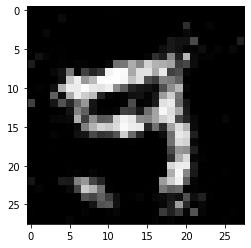

Epoch [148/200], Step [200/600], d_loss: 0.9089, g_loss: 1.5717, D(x): 0.68, D(G(z)): 0.28
Epoch [148/200], Step [400/600], d_loss: 1.0871, g_loss: 1.0092, D(x): 0.72, D(G(z)): 0.43
Epoch [148/200], Step [600/600], d_loss: 0.8191, g_loss: 1.6257, D(x): 0.76, D(G(z)): 0.31


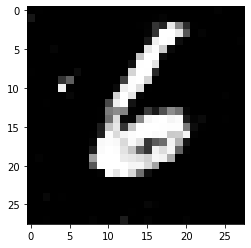

Epoch [149/200], Step [200/600], d_loss: 0.8436, g_loss: 1.6692, D(x): 0.70, D(G(z)): 0.29
Epoch [149/200], Step [400/600], d_loss: 0.7832, g_loss: 1.5756, D(x): 0.78, D(G(z)): 0.32
Epoch [149/200], Step [600/600], d_loss: 1.0292, g_loss: 1.7073, D(x): 0.66, D(G(z)): 0.30


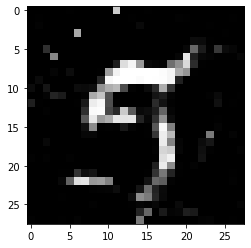

Epoch [150/200], Step [200/600], d_loss: 1.1495, g_loss: 1.4977, D(x): 0.67, D(G(z)): 0.33
Epoch [150/200], Step [400/600], d_loss: 0.8391, g_loss: 1.5200, D(x): 0.70, D(G(z)): 0.26
Epoch [150/200], Step [600/600], d_loss: 0.8282, g_loss: 1.5435, D(x): 0.74, D(G(z)): 0.30


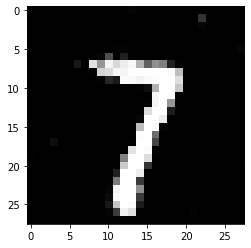

Epoch [151/200], Step [200/600], d_loss: 0.7588, g_loss: 1.5863, D(x): 0.77, D(G(z)): 0.30
Epoch [151/200], Step [400/600], d_loss: 1.1573, g_loss: 1.2948, D(x): 0.79, D(G(z)): 0.49
Epoch [151/200], Step [600/600], d_loss: 0.9190, g_loss: 1.3819, D(x): 0.76, D(G(z)): 0.35


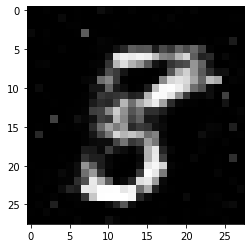

Epoch [152/200], Step [200/600], d_loss: 0.9870, g_loss: 1.6576, D(x): 0.63, D(G(z)): 0.26
Epoch [152/200], Step [400/600], d_loss: 1.1389, g_loss: 1.8322, D(x): 0.60, D(G(z)): 0.29
Epoch [152/200], Step [600/600], d_loss: 0.9985, g_loss: 1.9327, D(x): 0.68, D(G(z)): 0.32


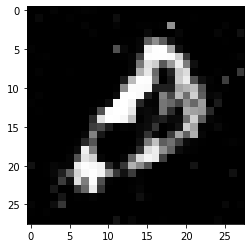

Epoch [153/200], Step [200/600], d_loss: 0.9597, g_loss: 1.4643, D(x): 0.71, D(G(z)): 0.33
Epoch [153/200], Step [400/600], d_loss: 1.1613, g_loss: 1.1239, D(x): 0.66, D(G(z)): 0.40
Epoch [153/200], Step [600/600], d_loss: 1.0713, g_loss: 1.7497, D(x): 0.66, D(G(z)): 0.33


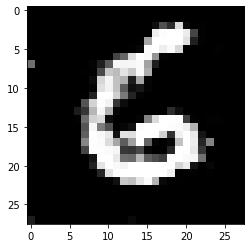

Epoch [154/200], Step [200/600], d_loss: 0.8334, g_loss: 1.5307, D(x): 0.69, D(G(z)): 0.28
Epoch [154/200], Step [400/600], d_loss: 0.8433, g_loss: 1.5414, D(x): 0.71, D(G(z)): 0.28
Epoch [154/200], Step [600/600], d_loss: 1.0327, g_loss: 1.5151, D(x): 0.69, D(G(z)): 0.34


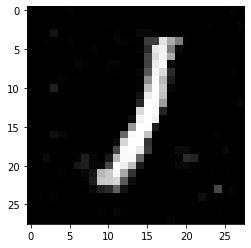

Epoch [155/200], Step [200/600], d_loss: 0.9032, g_loss: 1.6806, D(x): 0.75, D(G(z)): 0.34
Epoch [155/200], Step [400/600], d_loss: 0.7764, g_loss: 1.8784, D(x): 0.74, D(G(z)): 0.27
Epoch [155/200], Step [600/600], d_loss: 0.6877, g_loss: 1.7403, D(x): 0.81, D(G(z)): 0.31


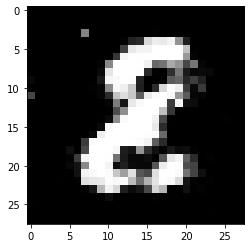

Epoch [156/200], Step [200/600], d_loss: 0.9983, g_loss: 1.3008, D(x): 0.72, D(G(z)): 0.35
Epoch [156/200], Step [400/600], d_loss: 0.9627, g_loss: 1.4725, D(x): 0.70, D(G(z)): 0.32
Epoch [156/200], Step [600/600], d_loss: 1.0571, g_loss: 1.6971, D(x): 0.61, D(G(z)): 0.26


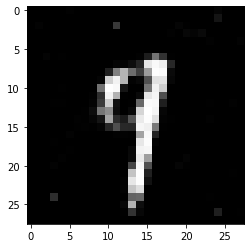

Epoch [157/200], Step [200/600], d_loss: 1.1259, g_loss: 1.1530, D(x): 0.63, D(G(z)): 0.37
Epoch [157/200], Step [400/600], d_loss: 0.6637, g_loss: 1.5642, D(x): 0.76, D(G(z)): 0.25
Epoch [157/200], Step [600/600], d_loss: 1.0029, g_loss: 1.8837, D(x): 0.71, D(G(z)): 0.35


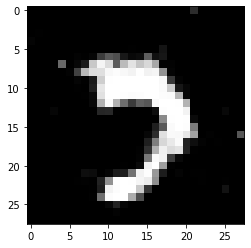

Epoch [158/200], Step [200/600], d_loss: 0.8841, g_loss: 1.7790, D(x): 0.74, D(G(z)): 0.33
Epoch [158/200], Step [400/600], d_loss: 0.9779, g_loss: 1.6557, D(x): 0.66, D(G(z)): 0.30
Epoch [158/200], Step [600/600], d_loss: 0.7963, g_loss: 1.5615, D(x): 0.72, D(G(z)): 0.25


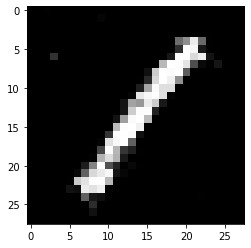

Epoch [159/200], Step [200/600], d_loss: 0.9032, g_loss: 1.2273, D(x): 0.74, D(G(z)): 0.37
Epoch [159/200], Step [400/600], d_loss: 1.0378, g_loss: 1.5457, D(x): 0.69, D(G(z)): 0.37
Epoch [159/200], Step [600/600], d_loss: 1.0360, g_loss: 1.3951, D(x): 0.64, D(G(z)): 0.31


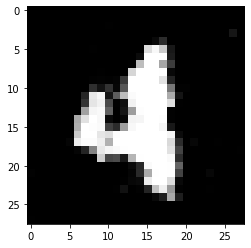

Epoch [160/200], Step [200/600], d_loss: 0.9104, g_loss: 1.9705, D(x): 0.71, D(G(z)): 0.30
Epoch [160/200], Step [400/600], d_loss: 1.1740, g_loss: 1.5689, D(x): 0.72, D(G(z)): 0.41
Epoch [160/200], Step [600/600], d_loss: 1.0821, g_loss: 1.4562, D(x): 0.65, D(G(z)): 0.31


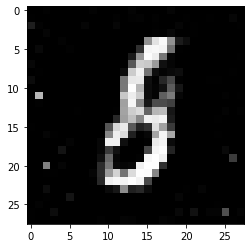

Epoch [161/200], Step [200/600], d_loss: 1.0575, g_loss: 1.7310, D(x): 0.63, D(G(z)): 0.33
Epoch [161/200], Step [400/600], d_loss: 0.9509, g_loss: 1.7985, D(x): 0.75, D(G(z)): 0.36
Epoch [161/200], Step [600/600], d_loss: 0.9717, g_loss: 1.8492, D(x): 0.69, D(G(z)): 0.33


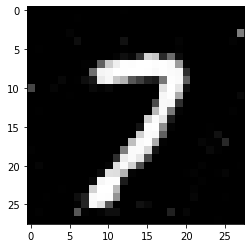

Epoch [162/200], Step [200/600], d_loss: 0.7443, g_loss: 1.7383, D(x): 0.79, D(G(z)): 0.30
Epoch [162/200], Step [400/600], d_loss: 0.7541, g_loss: 1.7477, D(x): 0.72, D(G(z)): 0.25
Epoch [162/200], Step [600/600], d_loss: 0.8040, g_loss: 1.8795, D(x): 0.70, D(G(z)): 0.27


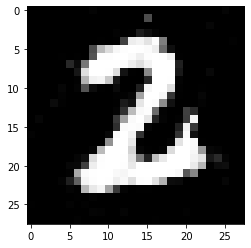

Epoch [163/200], Step [200/600], d_loss: 0.9360, g_loss: 1.3304, D(x): 0.75, D(G(z)): 0.35
Epoch [163/200], Step [400/600], d_loss: 0.7967, g_loss: 1.6039, D(x): 0.68, D(G(z)): 0.21
Epoch [163/200], Step [600/600], d_loss: 0.9009, g_loss: 1.8842, D(x): 0.70, D(G(z)): 0.30


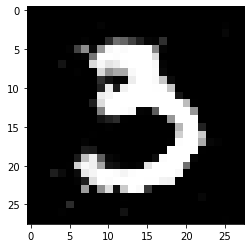

Epoch [164/200], Step [200/600], d_loss: 0.9111, g_loss: 1.3596, D(x): 0.69, D(G(z)): 0.31
Epoch [164/200], Step [400/600], d_loss: 0.8630, g_loss: 1.4224, D(x): 0.67, D(G(z)): 0.25
Epoch [164/200], Step [600/600], d_loss: 0.8185, g_loss: 1.5485, D(x): 0.67, D(G(z)): 0.22


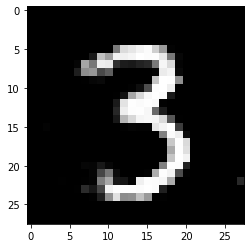

Epoch [165/200], Step [200/600], d_loss: 0.9119, g_loss: 1.4782, D(x): 0.68, D(G(z)): 0.31
Epoch [165/200], Step [400/600], d_loss: 0.9204, g_loss: 1.2768, D(x): 0.70, D(G(z)): 0.34
Epoch [165/200], Step [600/600], d_loss: 0.9257, g_loss: 1.7039, D(x): 0.74, D(G(z)): 0.36


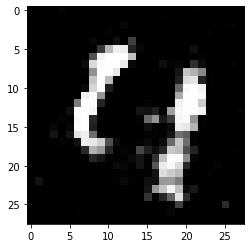

Epoch [166/200], Step [200/600], d_loss: 1.0023, g_loss: 1.2058, D(x): 0.72, D(G(z)): 0.37
Epoch [166/200], Step [400/600], d_loss: 1.1817, g_loss: 1.5313, D(x): 0.60, D(G(z)): 0.35
Epoch [166/200], Step [600/600], d_loss: 0.8545, g_loss: 1.3942, D(x): 0.75, D(G(z)): 0.33


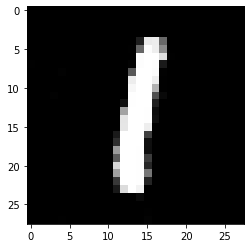

Epoch [167/200], Step [200/600], d_loss: 1.0633, g_loss: 1.2912, D(x): 0.67, D(G(z)): 0.37
Epoch [167/200], Step [400/600], d_loss: 0.9686, g_loss: 1.3240, D(x): 0.69, D(G(z)): 0.36
Epoch [167/200], Step [600/600], d_loss: 0.9327, g_loss: 1.7775, D(x): 0.60, D(G(z)): 0.22


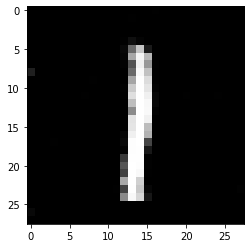

Epoch [168/200], Step [200/600], d_loss: 0.8780, g_loss: 1.6639, D(x): 0.66, D(G(z)): 0.25
Epoch [168/200], Step [400/600], d_loss: 0.9385, g_loss: 1.3669, D(x): 0.71, D(G(z)): 0.34
Epoch [168/200], Step [600/600], d_loss: 1.0671, g_loss: 1.2796, D(x): 0.68, D(G(z)): 0.40


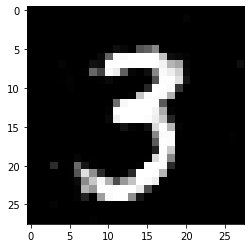

Epoch [169/200], Step [200/600], d_loss: 0.7991, g_loss: 1.5283, D(x): 0.72, D(G(z)): 0.29
Epoch [169/200], Step [400/600], d_loss: 0.8079, g_loss: 1.7696, D(x): 0.68, D(G(z)): 0.24
Epoch [169/200], Step [600/600], d_loss: 1.0271, g_loss: 1.6037, D(x): 0.69, D(G(z)): 0.36


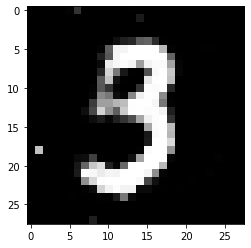

Epoch [170/200], Step [200/600], d_loss: 1.1774, g_loss: 1.2427, D(x): 0.66, D(G(z)): 0.40
Epoch [170/200], Step [400/600], d_loss: 1.0146, g_loss: 1.3744, D(x): 0.66, D(G(z)): 0.32
Epoch [170/200], Step [600/600], d_loss: 1.2420, g_loss: 1.9712, D(x): 0.59, D(G(z)): 0.33


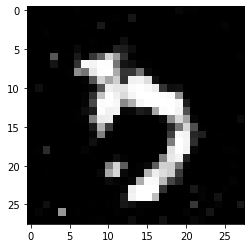

Epoch [171/200], Step [200/600], d_loss: 0.9877, g_loss: 1.4009, D(x): 0.67, D(G(z)): 0.32
Epoch [171/200], Step [400/600], d_loss: 1.1891, g_loss: 1.8356, D(x): 0.55, D(G(z)): 0.24
Epoch [171/200], Step [600/600], d_loss: 0.8120, g_loss: 1.7317, D(x): 0.72, D(G(z)): 0.29


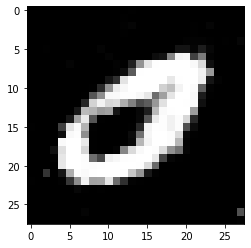

Epoch [172/200], Step [200/600], d_loss: 1.0803, g_loss: 1.2682, D(x): 0.68, D(G(z)): 0.37
Epoch [172/200], Step [400/600], d_loss: 0.8669, g_loss: 1.4215, D(x): 0.74, D(G(z)): 0.31
Epoch [172/200], Step [600/600], d_loss: 0.8685, g_loss: 1.6246, D(x): 0.73, D(G(z)): 0.30


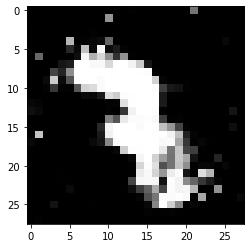

Epoch [173/200], Step [200/600], d_loss: 1.0395, g_loss: 1.4199, D(x): 0.69, D(G(z)): 0.36
Epoch [173/200], Step [400/600], d_loss: 0.8942, g_loss: 2.0623, D(x): 0.66, D(G(z)): 0.27
Epoch [173/200], Step [600/600], d_loss: 0.9550, g_loss: 1.2957, D(x): 0.72, D(G(z)): 0.35


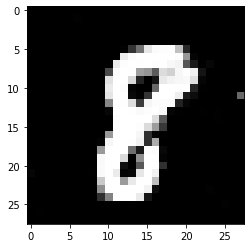

Epoch [174/200], Step [200/600], d_loss: 0.9454, g_loss: 1.6668, D(x): 0.68, D(G(z)): 0.29
Epoch [174/200], Step [400/600], d_loss: 0.8014, g_loss: 1.6518, D(x): 0.63, D(G(z)): 0.19
Epoch [174/200], Step [600/600], d_loss: 0.7778, g_loss: 1.7144, D(x): 0.72, D(G(z)): 0.26


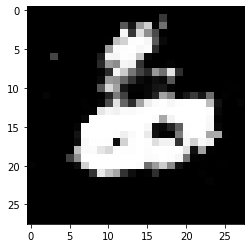

Epoch [175/200], Step [200/600], d_loss: 0.8607, g_loss: 1.5151, D(x): 0.71, D(G(z)): 0.30
Epoch [175/200], Step [400/600], d_loss: 0.8224, g_loss: 1.8997, D(x): 0.69, D(G(z)): 0.25
Epoch [175/200], Step [600/600], d_loss: 1.2171, g_loss: 1.6194, D(x): 0.66, D(G(z)): 0.39


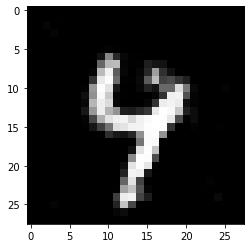

Epoch [176/200], Step [200/600], d_loss: 1.0945, g_loss: 1.5730, D(x): 0.67, D(G(z)): 0.38
Epoch [176/200], Step [400/600], d_loss: 1.1453, g_loss: 1.6423, D(x): 0.56, D(G(z)): 0.26
Epoch [176/200], Step [600/600], d_loss: 0.9740, g_loss: 1.8540, D(x): 0.72, D(G(z)): 0.33


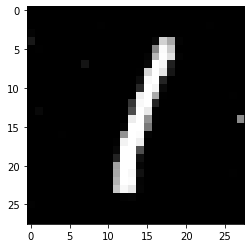

Epoch [177/200], Step [200/600], d_loss: 0.9995, g_loss: 1.5432, D(x): 0.75, D(G(z)): 0.37
Epoch [177/200], Step [400/600], d_loss: 0.8492, g_loss: 1.4750, D(x): 0.70, D(G(z)): 0.25
Epoch [177/200], Step [600/600], d_loss: 0.9515, g_loss: 1.5709, D(x): 0.68, D(G(z)): 0.31


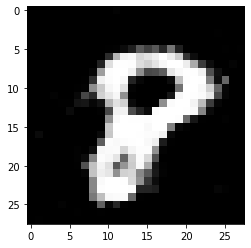

Epoch [178/200], Step [200/600], d_loss: 0.9186, g_loss: 1.6178, D(x): 0.69, D(G(z)): 0.31
Epoch [178/200], Step [400/600], d_loss: 1.0527, g_loss: 1.2824, D(x): 0.62, D(G(z)): 0.29
Epoch [178/200], Step [600/600], d_loss: 0.8628, g_loss: 1.4243, D(x): 0.75, D(G(z)): 0.33


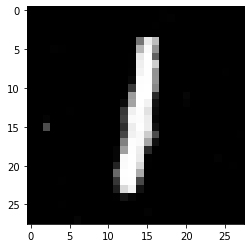

Epoch [179/200], Step [200/600], d_loss: 1.0481, g_loss: 1.8289, D(x): 0.64, D(G(z)): 0.31
Epoch [179/200], Step [400/600], d_loss: 0.9268, g_loss: 1.3143, D(x): 0.75, D(G(z)): 0.36
Epoch [179/200], Step [600/600], d_loss: 0.8589, g_loss: 1.7454, D(x): 0.65, D(G(z)): 0.24


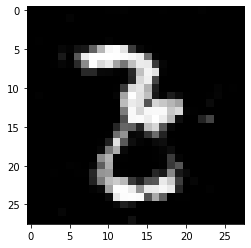

Epoch [180/200], Step [200/600], d_loss: 1.0715, g_loss: 1.4424, D(x): 0.55, D(G(z)): 0.23
Epoch [180/200], Step [400/600], d_loss: 0.8812, g_loss: 1.5349, D(x): 0.69, D(G(z)): 0.30
Epoch [180/200], Step [600/600], d_loss: 0.8276, g_loss: 1.7998, D(x): 0.71, D(G(z)): 0.28


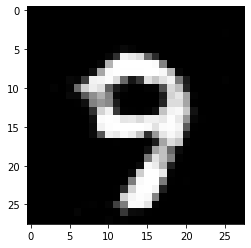

Epoch [181/200], Step [200/600], d_loss: 0.9645, g_loss: 1.6719, D(x): 0.68, D(G(z)): 0.29
Epoch [181/200], Step [400/600], d_loss: 0.9162, g_loss: 1.4981, D(x): 0.67, D(G(z)): 0.30
Epoch [181/200], Step [600/600], d_loss: 1.0542, g_loss: 1.4578, D(x): 0.67, D(G(z)): 0.35


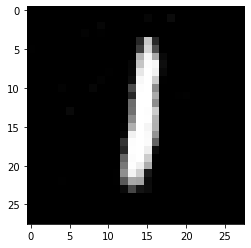

Epoch [182/200], Step [200/600], d_loss: 1.0832, g_loss: 1.1736, D(x): 0.68, D(G(z)): 0.38
Epoch [182/200], Step [400/600], d_loss: 1.0687, g_loss: 1.2430, D(x): 0.67, D(G(z)): 0.37
Epoch [182/200], Step [600/600], d_loss: 1.0299, g_loss: 1.4527, D(x): 0.65, D(G(z)): 0.31


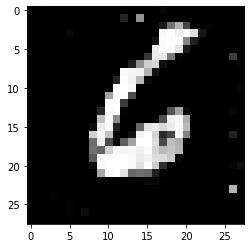

Epoch [183/200], Step [200/600], d_loss: 1.0941, g_loss: 1.2148, D(x): 0.65, D(G(z)): 0.36
Epoch [183/200], Step [400/600], d_loss: 0.9519, g_loss: 1.8394, D(x): 0.73, D(G(z)): 0.35
Epoch [183/200], Step [600/600], d_loss: 0.9415, g_loss: 1.8627, D(x): 0.66, D(G(z)): 0.26


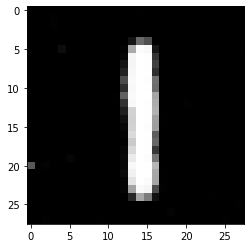

Epoch [184/200], Step [200/600], d_loss: 0.9571, g_loss: 2.0710, D(x): 0.62, D(G(z)): 0.24
Epoch [184/200], Step [400/600], d_loss: 0.9349, g_loss: 1.9766, D(x): 0.63, D(G(z)): 0.26
Epoch [184/200], Step [600/600], d_loss: 1.1584, g_loss: 1.1321, D(x): 0.64, D(G(z)): 0.38


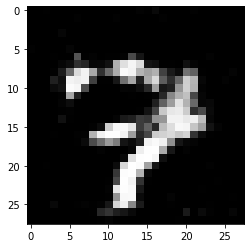

Epoch [185/200], Step [200/600], d_loss: 1.0003, g_loss: 1.5198, D(x): 0.70, D(G(z)): 0.33
Epoch [185/200], Step [400/600], d_loss: 0.8021, g_loss: 1.4103, D(x): 0.77, D(G(z)): 0.33
Epoch [185/200], Step [600/600], d_loss: 1.0793, g_loss: 1.3887, D(x): 0.66, D(G(z)): 0.36


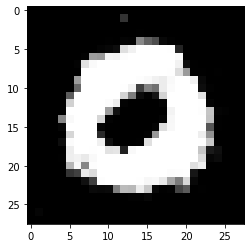

Epoch [186/200], Step [200/600], d_loss: 1.1975, g_loss: 1.2609, D(x): 0.67, D(G(z)): 0.43
Epoch [186/200], Step [400/600], d_loss: 1.0033, g_loss: 1.0997, D(x): 0.75, D(G(z)): 0.41
Epoch [186/200], Step [600/600], d_loss: 1.0473, g_loss: 1.2960, D(x): 0.77, D(G(z)): 0.45


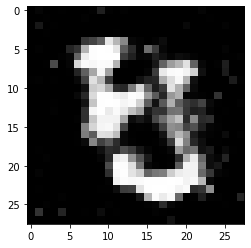

Epoch [187/200], Step [200/600], d_loss: 0.9960, g_loss: 1.5393, D(x): 0.65, D(G(z)): 0.31
Epoch [187/200], Step [400/600], d_loss: 0.8363, g_loss: 1.5992, D(x): 0.77, D(G(z)): 0.34
Epoch [187/200], Step [600/600], d_loss: 1.0473, g_loss: 1.4291, D(x): 0.65, D(G(z)): 0.34


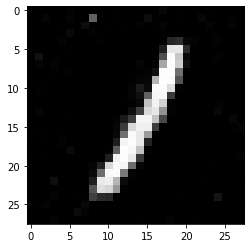

Epoch [188/200], Step [200/600], d_loss: 1.0585, g_loss: 1.6238, D(x): 0.72, D(G(z)): 0.38
Epoch [188/200], Step [400/600], d_loss: 0.8372, g_loss: 1.5129, D(x): 0.77, D(G(z)): 0.36
Epoch [188/200], Step [600/600], d_loss: 0.8867, g_loss: 1.6178, D(x): 0.66, D(G(z)): 0.26


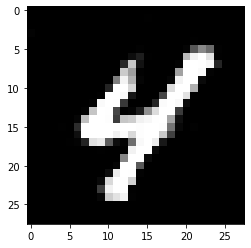

Epoch [189/200], Step [200/600], d_loss: 0.8306, g_loss: 1.6437, D(x): 0.70, D(G(z)): 0.25
Epoch [189/200], Step [400/600], d_loss: 0.8670, g_loss: 1.8456, D(x): 0.73, D(G(z)): 0.30
Epoch [189/200], Step [600/600], d_loss: 1.0496, g_loss: 1.0543, D(x): 0.67, D(G(z)): 0.33


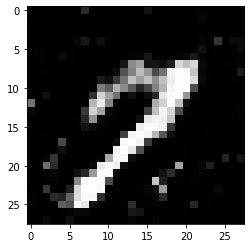

Epoch [190/200], Step [200/600], d_loss: 0.9793, g_loss: 1.4129, D(x): 0.68, D(G(z)): 0.31
Epoch [190/200], Step [400/600], d_loss: 1.1052, g_loss: 1.4262, D(x): 0.64, D(G(z)): 0.33
Epoch [190/200], Step [600/600], d_loss: 1.0859, g_loss: 1.6055, D(x): 0.64, D(G(z)): 0.35


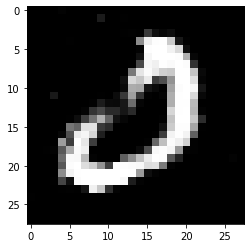

Epoch [191/200], Step [200/600], d_loss: 1.1642, g_loss: 1.1164, D(x): 0.78, D(G(z)): 0.49
Epoch [191/200], Step [400/600], d_loss: 1.1000, g_loss: 1.8318, D(x): 0.63, D(G(z)): 0.32
Epoch [191/200], Step [600/600], d_loss: 0.9820, g_loss: 1.0462, D(x): 0.68, D(G(z)): 0.34


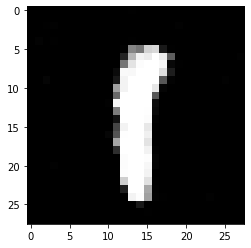

Epoch [192/200], Step [200/600], d_loss: 1.0559, g_loss: 1.2828, D(x): 0.67, D(G(z)): 0.36
Epoch [192/200], Step [400/600], d_loss: 1.0772, g_loss: 1.6242, D(x): 0.69, D(G(z)): 0.37
Epoch [192/200], Step [600/600], d_loss: 1.0188, g_loss: 1.3549, D(x): 0.70, D(G(z)): 0.36


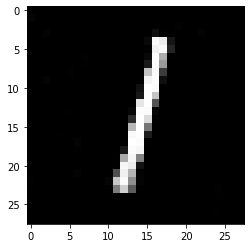

Epoch [193/200], Step [200/600], d_loss: 1.1222, g_loss: 1.3587, D(x): 0.71, D(G(z)): 0.42
Epoch [193/200], Step [400/600], d_loss: 1.0194, g_loss: 1.5452, D(x): 0.72, D(G(z)): 0.38
Epoch [193/200], Step [600/600], d_loss: 1.0289, g_loss: 1.2580, D(x): 0.68, D(G(z)): 0.37


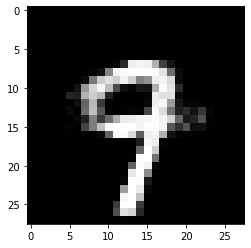

Epoch [194/200], Step [200/600], d_loss: 0.9290, g_loss: 2.2238, D(x): 0.71, D(G(z)): 0.31
Epoch [194/200], Step [400/600], d_loss: 1.0039, g_loss: 1.4129, D(x): 0.68, D(G(z)): 0.33
Epoch [194/200], Step [600/600], d_loss: 1.1086, g_loss: 1.5463, D(x): 0.69, D(G(z)): 0.36


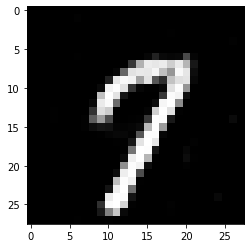

Epoch [195/200], Step [200/600], d_loss: 0.8589, g_loss: 1.9477, D(x): 0.64, D(G(z)): 0.23
Epoch [195/200], Step [400/600], d_loss: 0.9246, g_loss: 1.6613, D(x): 0.68, D(G(z)): 0.29
Epoch [195/200], Step [600/600], d_loss: 0.8798, g_loss: 1.4186, D(x): 0.70, D(G(z)): 0.29


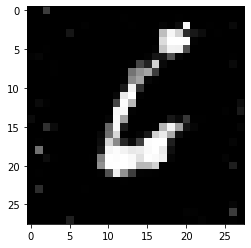

Epoch [196/200], Step [200/600], d_loss: 0.9111, g_loss: 1.6463, D(x): 0.66, D(G(z)): 0.29
Epoch [196/200], Step [400/600], d_loss: 0.8338, g_loss: 1.7745, D(x): 0.64, D(G(z)): 0.22
Epoch [196/200], Step [600/600], d_loss: 0.9320, g_loss: 1.6865, D(x): 0.69, D(G(z)): 0.31


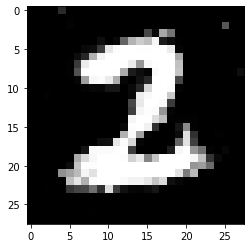

Epoch [197/200], Step [200/600], d_loss: 0.9117, g_loss: 1.4972, D(x): 0.71, D(G(z)): 0.35
Epoch [197/200], Step [400/600], d_loss: 0.9571, g_loss: 1.6093, D(x): 0.72, D(G(z)): 0.34
Epoch [197/200], Step [600/600], d_loss: 0.8062, g_loss: 1.5486, D(x): 0.74, D(G(z)): 0.29


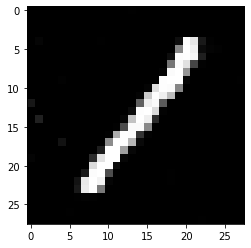

Epoch [198/200], Step [200/600], d_loss: 1.0194, g_loss: 1.6214, D(x): 0.75, D(G(z)): 0.38
Epoch [198/200], Step [400/600], d_loss: 1.0088, g_loss: 1.5136, D(x): 0.72, D(G(z)): 0.33
Epoch [198/200], Step [600/600], d_loss: 1.0005, g_loss: 1.5701, D(x): 0.64, D(G(z)): 0.29


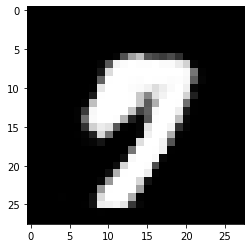

Epoch [199/200], Step [200/600], d_loss: 1.1222, g_loss: 1.3341, D(x): 0.68, D(G(z)): 0.40
Epoch [199/200], Step [400/600], d_loss: 0.9546, g_loss: 1.5524, D(x): 0.73, D(G(z)): 0.37
Epoch [199/200], Step [600/600], d_loss: 0.9502, g_loss: 1.2487, D(x): 0.66, D(G(z)): 0.30


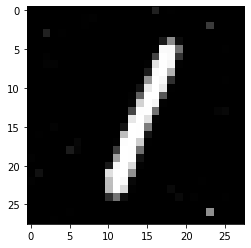

In [16]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    
    # Reshape sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    fake_images_clone = fake_images.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

# Save the model checkpoints 
torch.save(G.state_dict(), 'gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200.ckpt')
torch.save(D.state_dict(), 'gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200.ckpt')

## Create Augmented Dataset

In [0]:
# Device setting
D = D.to(device)
G = G.to(device)

# Create an equal number of fake images
aug_size = len(mnist)
z = torch.randn(aug_size, latent_size).to(device)
fake_dataset_images = G(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(mnist), image_size))
for i in range(len(mnist)):
  original_data[i,:] = mnist[i][0].reshape(image_size,)


In [0]:
# Create augmented dataset
class AugDataset(torch.utils.data.Dataset):
    def __init__(self, original_data, generated_data):
        # Load Data 
        self.x_train = np.vstack((original_data, generated_data[0].numpy()))
      
        self.y_train = np.vstack((np.ones(((original_data.shape[0], 1))), np.zeros(((generated_data[0].numpy().shape[0], 1)))))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = AugDataset(original_data, fake_dataset)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

# Create Classifier

In [0]:
# Fully connected neural network with the same architecture as the Discriminator
class NeuralNet(nn.Module):

    def __init__(self, image_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(image_size, hidden_size) 
        self.relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sig(out)
        return out

# Create model
clf = NeuralNet(image_size, hidden_size).to(device)

## Train Classifier

In [49]:
# Train the model
num_epochs_clf = 1
total_step = len(train_loader)
for epoch in range(num_epochs_clf):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)
        
        # Forward pass
        outputs = clf(images.float())
        loss = clf.criterion(outputs, labels.float())
        
        # Backward and optimize
        clf.optimizer.zero_grad()
        loss.backward()
        clf.optimizer.step()

        if i == 200:
          break
        
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_clf, i+1, total_step, loss.item()))

Epoch [1/1], Step [5/960], Loss: 0.5488
Epoch [1/1], Step [10/960], Loss: 0.5657
Epoch [1/1], Step [15/960], Loss: 0.5632
Epoch [1/1], Step [20/960], Loss: 0.5230
Epoch [1/1], Step [25/960], Loss: 0.5506
Epoch [1/1], Step [30/960], Loss: 0.4978
Epoch [1/1], Step [35/960], Loss: 0.4917
Epoch [1/1], Step [40/960], Loss: 0.5345
Epoch [1/1], Step [45/960], Loss: 0.4921
Epoch [1/1], Step [50/960], Loss: 0.4924
Epoch [1/1], Step [55/960], Loss: 0.4103
Epoch [1/1], Step [60/960], Loss: 0.4353
Epoch [1/1], Step [65/960], Loss: 0.4506
Epoch [1/1], Step [70/960], Loss: 0.3898
Epoch [1/1], Step [75/960], Loss: 0.4118
Epoch [1/1], Step [80/960], Loss: 0.3644
Epoch [1/1], Step [85/960], Loss: 0.3140
Epoch [1/1], Step [90/960], Loss: 0.3668
Epoch [1/1], Step [95/960], Loss: 0.4049
Epoch [1/1], Step [100/960], Loss: 0.3715
Epoch [1/1], Step [105/960], Loss: 0.3179
Epoch [1/1], Step [110/960], Loss: 0.2830
Epoch [1/1], Step [115/960], Loss: 0.2807
Epoch [1/1], Step [120/960], Loss: 0.2767
Epoch [1/1],

## Test Classifier

In [47]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)

        outputs = clf(images.float())
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        predicted_labels = torch.where(outputs > 0.5, real_labels, fake_labels)


        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 24000 test images: 73.1875 %


# Fine Tuning

In [0]:
def train_gan(D, G, D_save_loc, G_save_loc, d_optimizer, g_optimizer, latent_size, data_loader, num_epochs, batch_size, criterion, device):
    total_step = len(data_loader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            images = images.reshape(batch_size, -1).to(device)
            
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels)
            
            # Backprop and optimize
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                      .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                              real_score.mean().item(), fake_score.mean().item()))
        
        
        # Reshape sampled images
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

        fake_images_clone = fake_images.clone()
        im = denorm(fake_images_clone[0]).cpu().detach().numpy()
        im = (im * 255).astype(np.uint8)
        im = im.reshape((28, 28))
        imgplot = plt.imshow(im, cmap='gray')
        plt.show()

    # Save the model checkpoints 
    torch.save(G.state_dict(), G_save_loc)
    torch.save(D.state_dict(), D_save_loc)

    return D, G

Epoch [0/200], Step [200/600], d_loss: 12.8285, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00
Epoch [0/200], Step [400/600], d_loss: 12.9330, g_loss: 0.0000, D(x): 0.84, D(G(z)): 1.00
Epoch [0/200], Step [600/600], d_loss: 12.8656, g_loss: 0.0000, D(x): 0.81, D(G(z)): 1.00


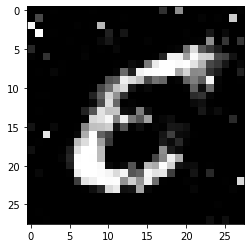

Epoch [1/200], Step [200/600], d_loss: 13.1001, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00
Epoch [1/200], Step [400/600], d_loss: 13.5515, g_loss: 0.0000, D(x): 0.81, D(G(z)): 1.00
Epoch [1/200], Step [600/600], d_loss: 13.4876, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00


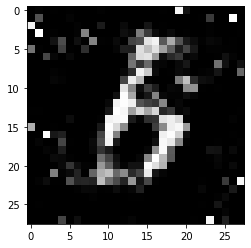

Epoch [2/200], Step [200/600], d_loss: 14.0324, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00
Epoch [2/200], Step [400/600], d_loss: 14.0856, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [2/200], Step [600/600], d_loss: 14.5538, g_loss: 0.0000, D(x): 0.79, D(G(z)): 1.00


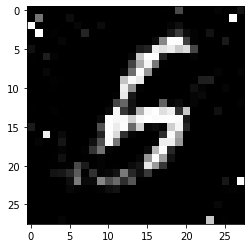

Epoch [3/200], Step [200/600], d_loss: 14.7451, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [3/200], Step [400/600], d_loss: 14.4939, g_loss: 0.0000, D(x): 0.84, D(G(z)): 1.00
Epoch [3/200], Step [600/600], d_loss: 15.0985, g_loss: 0.0000, D(x): 0.81, D(G(z)): 1.00


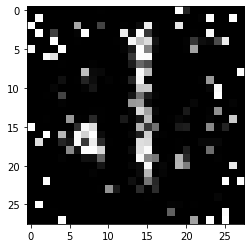

Epoch [4/200], Step [200/600], d_loss: 15.1547, g_loss: 0.0000, D(x): 0.85, D(G(z)): 1.00
Epoch [4/200], Step [400/600], d_loss: 16.3930, g_loss: 0.0000, D(x): 0.79, D(G(z)): 1.00
Epoch [4/200], Step [600/600], d_loss: 15.8574, g_loss: 0.0000, D(x): 0.80, D(G(z)): 1.00


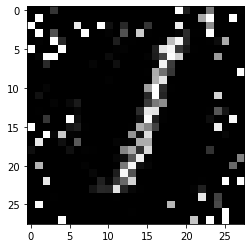

Epoch [5/200], Step [200/600], d_loss: 16.0281, g_loss: 0.0000, D(x): 0.81, D(G(z)): 1.00
Epoch [5/200], Step [400/600], d_loss: 17.5561, g_loss: 0.0000, D(x): 0.79, D(G(z)): 1.00
Epoch [5/200], Step [600/600], d_loss: 17.4447, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00


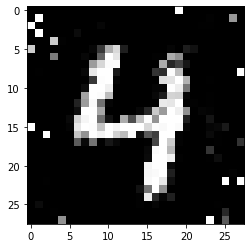

Epoch [6/200], Step [200/600], d_loss: 18.4444, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [6/200], Step [400/600], d_loss: 17.7260, g_loss: 0.0000, D(x): 0.80, D(G(z)): 1.00
Epoch [6/200], Step [600/600], d_loss: 19.2992, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00


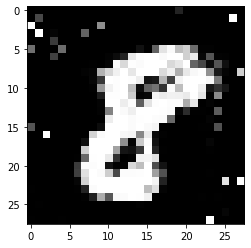

Epoch [7/200], Step [200/600], d_loss: 19.5197, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00
Epoch [7/200], Step [400/600], d_loss: 20.1691, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [7/200], Step [600/600], d_loss: 19.9313, g_loss: 0.0000, D(x): 0.79, D(G(z)): 1.00


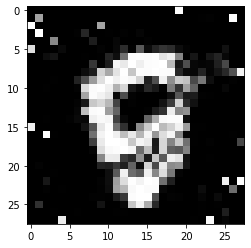

Epoch [8/200], Step [200/600], d_loss: 21.6579, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [8/200], Step [400/600], d_loss: 21.8287, g_loss: 0.0000, D(x): 0.85, D(G(z)): 1.00
Epoch [8/200], Step [600/600], d_loss: 21.0523, g_loss: 0.0000, D(x): 0.81, D(G(z)): 1.00


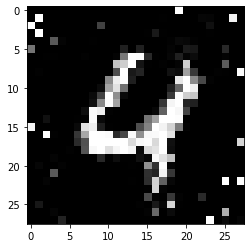

Epoch [9/200], Step [200/600], d_loss: 21.4407, g_loss: 0.0000, D(x): 0.84, D(G(z)): 1.00
Epoch [9/200], Step [400/600], d_loss: 21.7363, g_loss: 0.0000, D(x): 0.83, D(G(z)): 1.00
Epoch [9/200], Step [600/600], d_loss: 22.2042, g_loss: 0.0000, D(x): 0.84, D(G(z)): 1.00


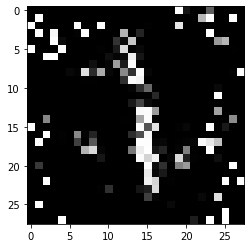

Epoch [10/200], Step [200/600], d_loss: 22.8453, g_loss: 0.0000, D(x): 0.82, D(G(z)): 1.00
Epoch [10/200], Step [400/600], d_loss: 23.9560, g_loss: 0.0000, D(x): 0.84, D(G(z)): 1.00


KeyboardInterrupt: ignored

In [52]:
D, G = train_gan(clf, G, 'gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200+ft1.ckpt', 'gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200+ft1.ckpt', d_optimizer, g_optimizer, latent_size, data_loader, num_epochs, batch_size, criterion, device)